# Titanic Project - PART 1 - Cleaning Data

In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import Counter
from sklearn.preprocessing import PowerTransformer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Lasso, LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
from sklearn.svm import SVR
from sklearn.utils import shuffle
from sklearn import datasets
from tqdm import tqdm as progress_bar

In [252]:
#Make sure to be able to see all columns and rows in the data set.
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", None)

## Load the data

In [3]:
data_train = pd.read_csv("C:/Users/meykevandenbos/Documents/Meyke persoonlijk/Techionista/ML/Titanic/train.csv")
data_test = pd.read_csv("C:/Users/meykevandenbos/Documents/Meyke persoonlijk/Techionista/ML/Titanic/test.csv")

I will concatenate both datasets (with survival and without survival). I also create a copy 'data_raw_duplicate'  to be on the safe side. 

In [4]:
data_raw = pd.concat([data_train, data_test])
data_raw_duplicate = pd.concat([data_train, data_test])

In [5]:
data_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
data_raw.shape

(1309, 12)

In [7]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


## Splitting data by Type

In [8]:
continuous = ['Age','Fare']

discrete = ['PassengerId','Survived','SibSp','Parch']

ordinal = ['Pclass']

nominal = ['Name','Sex','Ticket','Cabin','Embarked']

## Let's look at missing values first

### CONTINUOUS

In [9]:
data_raw[continuous].head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [10]:
data_raw[continuous].isna().sum().sort_values(ascending=False)

Age     263
Fare      1
dtype: int64

In [11]:
data_raw[data_raw['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q
410,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


There are quiet a few ages missing from the dataset. 
- Can we find a better estimate of the age by looking at whom these passengers travelled with? 

In order to deal with these missing values, I will first create a column that indicates I imputed the ages for these people. If I can find a better way to impute, I can still see which values belong to the original dataset and which were imputed.
* Column 'AgeHelperColumn' == 1 if the Age value is not imputed.
* Column 'AgeHelperColumn' == 0 if the Age valye is imputed.

In [12]:
data_raw['AgeHelperColumn'] = data_raw.apply(lambda row: 1 if row['Age'] > -1 else 0, axis=1)

In [13]:
data_raw[data_raw['Fare'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeHelperColumn
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1


The missing value for the Fare belongs to a third class male passenger. I think the Fare of all third class passengers was rather low. And I am guessing, the marginal differences here will not influence the chances for survival.

<AxesSubplot:xlabel='Fare', ylabel='Count'>

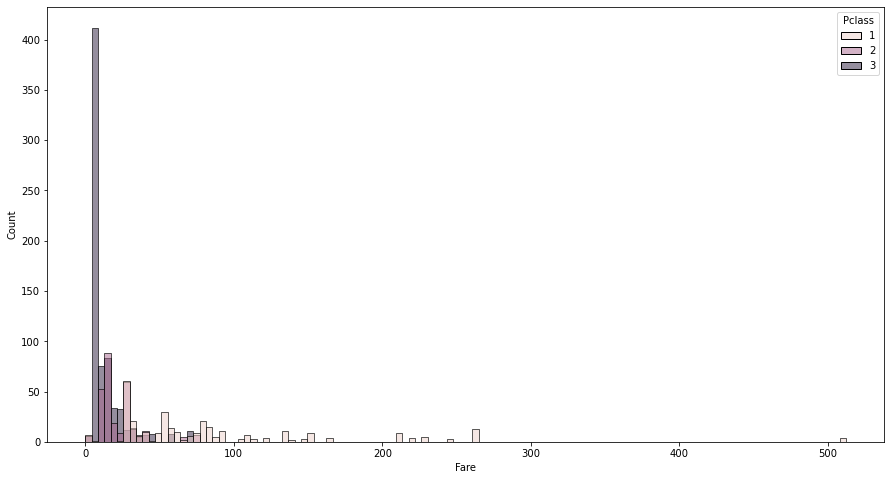

In [14]:
plt.figure(figsize=(15,8))
sns.histplot(data=data_raw, x="Fare", hue="Pclass")

In [15]:
median = data_raw.groupby(["Pclass"])["Fare"].median()
mean = data_raw.groupby(["Pclass"])["Fare"].mean()
fare = pd.concat([median, mean], axis=1, keys = ["Median Fare", "Mean Fare"])
fare

,Median Fare,Mean Fare
Pclass,,
1,60.0000,87.508992
2,15.0458,21.179196
3,8.0500,13.302889


In [16]:
data_raw['Fare'] = data_raw['Fare'].fillna(8.0500)

## DISCRETE

In [17]:
data_raw[discrete].head()

,PassengerId,Survived,SibSp,Parch
0,1,0.0,1,0
1,2,1.0,1,0
2,3,1.0,0,0
3,4,1.0,1,0
4,5,0.0,0,0


In [18]:
data_raw[discrete].isna().sum().sort_values(ascending=False)

Survived       418
Parch            0
SibSp            0
PassengerId      0
dtype: int64

It looks like we have no missing values, except for the Survived... which is the column that we need to predict. 

## ORDINAL

In [19]:
data_raw[ordinal].head()

,Pclass
0,3
1,1
2,3
3,1
4,3


In [20]:
data_raw[ordinal].isna().sum().sort_values(ascending=False)

Pclass    0
dtype: int64

### NOMINAL

In [21]:
data_raw[nominal].head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


In [22]:
data_raw[nominal].isna().sum().sort_values(ascending=False)

Cabin       1014
Embarked       2
Ticket         0
Sex            0
Name           0
dtype: int64

It looks like we miss a lot of Cabin numbers/information. I do not think the Cabin info itself will have an influence on the survival chances of the passengers. It might however provide additional usefull information regarding the passengers later on. I will impute the missing Cabin values with NoCabin.

In [23]:
data_raw['Cabin'] = data_raw['Cabin'].fillna('U')

In [24]:
data_raw[data_raw['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeHelperColumn
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1


From two first class female passengers, we do not know where they embarked. Funnily enough, it looks like they have no family relationship (SibSp and Parch columns do not show proof of such a relation), but they are seem to be travelling together (see the columns Ticket and Cabin). Let's check if there are more people residing in the same Cabin. 

In [25]:
data_raw.loc[(data_raw['Cabin'] == 'B28')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeHelperColumn
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1


In [26]:
data_raw.groupby(['Pclass','Embarked'])['Embarked'].count()

Pclass  Embarked
1       C           141
        Q             3
        S           177
2       C            28
        Q             7
        S           242
3       C           101
        Q           113
        S           495
Name: Embarked, dtype: int64

Since I cannot find a good imputation value for the location the two ladies embarked, I will fill the missing values with 'NoEmbarked'.

In [27]:
data_raw['Embarked'] = data_raw['Embarked'].fillna('NoEmbarked')

# Titanic Project - PART 2 - EDA

Feateare engineering:
- sex >  One hot encoding
- embarked > One hot encoding
- Age groups > ?
- Age, box-cox
- Fare groups > ?
- Fare, box-cox
- Deck, from Cabin > One hot encoding
- Title, from Name > One hot encoding
- Mother-child... both survive, both die
- Family count... does family size influence the survival chances?
- Travelling together yes/no > is that enough? can we do something more with this?

#### SEX

In [28]:
data_raw_Sex = pd.get_dummies(data_raw[['Sex']],prefix='Sex')
data_raw = pd.concat([data_raw,data_raw_Sex],axis=1)

In [29]:
nominal.append('Sex_female')
nominal.append('Sex_male')

#### EMBARKED

In [30]:
data_raw_Embarked = pd.get_dummies(data_raw[['Embarked']],prefix='Emb')
data_raw = pd.concat([data_raw,data_raw_Embarked],axis=1)

In [31]:
nominal.append('Emb_C')
nominal.append('Emb_NoEmbarked')
nominal.append('Emb_Q')
nominal.append('Emb_S')

#### TITLE

In [32]:
data_raw['Title']=data_raw.apply(lambda row: "Mr." if "Mr." in row.Name else 
                             ("Mrs." if "Mrs." in row.Name else
                              ("Miss." if "Miss." in row.Name else
                               ("Miss." if "Ms." in row.Name else
                                ("Master." if "Master." in row.Name else
                                 ("Rev." if "Rev." in row.Name else
                                  ("Dr." if "Dr." in row.Name else "NoTitle")))))), axis=1 )

In [33]:
data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeHelperColumn,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,0,1,0,0,0,1,Mr.
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,0,1,0,0,0,Mrs.
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,1,1,0,0,0,0,1,Miss.
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,0,0,0,0,1,Mrs.
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,1,0,1,0,0,0,1,Mr.


In [34]:
data_raw.groupby(['Title'])['PassengerId'].count()

Title
Dr.          8
Master.     61
Miss.      262
Mr.        757
Mrs.       197
NoTitle     16
Rev.         8
Name: PassengerId, dtype: int64

In [35]:
data_raw.loc[(data_raw['Title'] == 'Rev.')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeHelperColumn,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,Title
149,150,0.0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.000,U,S,1,0,1,0,0,0,1,Rev.
150,151,0.0,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.525,U,S,1,0,1,0,0,0,1,Rev.
249,250,0.0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.000,U,S,1,0,1,0,0,0,1,Rev.
626,627,0.0,2,"Kirkland, Rev. Charles Leonard",male,57.0,0,0,219533,12.350,U,Q,1,0,1,0,0,1,0,Rev.
848,849,0.0,2,"Harper, Rev. John",male,28.0,0,1,248727,33.000,U,S,1,0,1,0,0,0,1,Rev.
886,887,0.0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.000,U,S,1,0,1,0,0,0,1,Rev.
149,1041,NaN,2,"Lahtinen, Rev. William",male,30.0,1,1,250651,26.000,U,S,1,0,1,0,0,0,1,Rev.
164,1056,NaN,2,"Peruschitz, Rev. Joseph Maria",male,41.0,0,0,237393,13.000,U,S,1,0,1,0,0,0,1,Rev.


All titles that we did not extract belong to people in the first class.

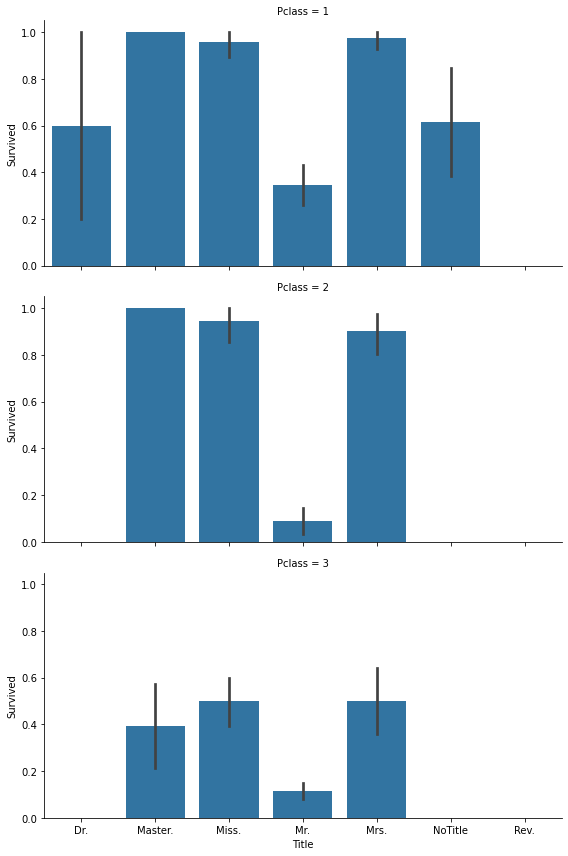

In [36]:
g = sns.FacetGrid(data_raw, row="Pclass", height=4, aspect=2)
g.map(sns.barplot, "Title", "Survived", order=["Dr.","Master.","Miss.","Mr.","Mrs.","NoTitle","Rev."])

I will not specify the NoTitle further. Since they are with so few, I do not think this will help the model predict the chance to survive the Titanic. 

In [37]:
data_raw_Title = pd.get_dummies(data_raw[['Title']],prefix='T')
data_raw = pd.concat([data_raw,data_raw_Title],axis=1)

In [38]:
nominal.append('T_Dr.')
nominal.append('T_Master.')
nominal.append('T_Miss.')
nominal.append('T_Mr.')
nominal.append('T_Mrs.')
nominal.append('T_NoTitle')
nominal.append('T_Rev.')

#### DECK

In [39]:
data_raw['Deck']= data_raw.apply(lambda row: "A" if "A" in row.Cabin else 
                                 ("B" if "B" in row.Cabin else 
                                  ("C" if "C" in row.Cabin else 
                                   ("D" if "D" in row.Cabin else 
                                    ("E" if "E" in row.Cabin else 
                                     ("F" if "F" in row.Cabin else 
                                      ("G" if "G" in row.Cabin else 
                                       ("T" if "T" in row.Cabin else "U"))))))), axis=1)

In [40]:
data_raw.groupby(['Deck'])['PassengerId'].count()

Deck
A      22
B      65
C      94
D      46
E      44
F      18
G       5
T       1
U    1014
Name: PassengerId, dtype: int64

In [41]:
data_raw.loc[(data_raw['Deck'] == 'A')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeHelperColumn,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,Title,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,Deck
23,24,1.0,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,A
96,97,0.0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C,1,0,1,1,0,0,0,Mr.,0,0,0,1,0,0,0,A
174,175,0.0,1,"Smith, Mr. James Clinch",male,56.0,0,0,17764,30.6958,A7,C,1,0,1,1,0,0,0,Mr.,0,0,0,1,0,0,0,A
185,186,0.0,1,"Rood, Mr. Hugh Roscoe",male,NaN,0,0,113767,50.0000,A32,S,0,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,A
209,210,1.0,1,"Blank, Mr. Henry",male,40.0,0,0,112277,31.0000,A31,C,1,0,1,1,0,0,0,Mr.,0,0,0,1,0,0,0,A
284,285,0.0,1,"Smith, Mr. Richard William",male,NaN,0,0,113056,26.0000,A19,S,0,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,A
445,446,1.0,1,"Dodge, Master. Washington",male,4.0,0,2,33638,81.8583,A34,S,1,0,1,0,0,0,1,Master.,0,1,0,0,0,0,0,A
475,476,0.0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0000,A14,S,0,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,A
556,557,1.0,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,C,1,1,0,1,0,0,0,NoTitle,0,0,0,0,0,1,0,A
583,584,0.0,1,"Ross, Mr. John Hugo",male,36.0,0,0,13049,40.1250,A10,C,1,0,1,1,0,0,0,Mr.,0,0,0,1,0,0,0,A


In [42]:
data_raw.groupby(['Deck','Pclass'])['PassengerId'].count()

Deck  Pclass
A     1          22
B     1          65
C     1          94
D     1          40
      2           6
E     1          34
      2           4
      3           6
F     2          13
      3           5
G     3           5
T     1           1
U     1          67
      2         254
      3         693
Name: PassengerId, dtype: int64

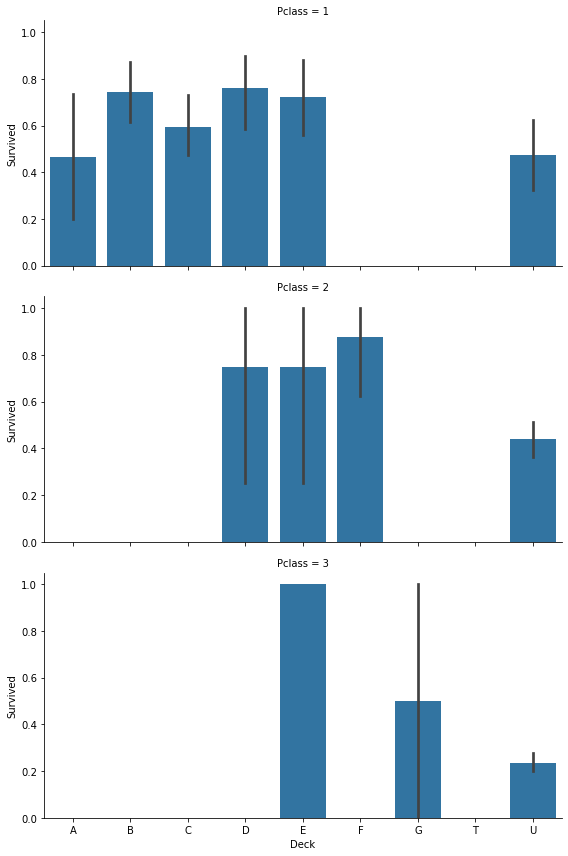

In [43]:
h = sns.FacetGrid(data_raw, row="Pclass", height=4, aspect=2)
h.map(sns.barplot, "Deck", "Survived", order=["A","B","C","D","E","F","G","T","U"])

In [44]:
data_raw_Deck = pd.get_dummies(data_raw[['Deck']],prefix='D')
data_raw = pd.concat([data_raw,data_raw_Deck],axis=1)

In [45]:
nominal.append('Deck')
nominal.append('D_A')
nominal.append('D_B')
nominal.append('D_C')
nominal.append('D_D')
nominal.append('D_E')
nominal.append('D_F')
nominal.append('D_G')
nominal.append('D_T')
nominal.append('D_U')

#### FARE

In order to normalize the continous variables, I will use a box-cox transformation. The function is added below. 
Since box-cox only operates on strictly positive numbers (0 is not allowed), I create a temporary new column FarePlus where I add + 0.001 to all fares to avoid 0 values. I will drop this column once the box-cox transformation is realized.

In [46]:
data_raw['Fare'].min()

0.0

In [47]:
data_raw['FarePlus'] = data_raw.apply(lambda row: row.Fare + 0.001, axis = 1)

In [48]:
# I use a function to normalize the continuous columns with box-cox 
ToTransform = ['FarePlus']

new_transformed_columns = []

for column in ToTransform:
    X = data_raw[[column]]
    pt = PowerTransformer(method="box-cox", standardize=False) 
    #fit the column
    box_cox = pt.fit(X)
    #Check if the lambda is between -3 and 3
    lambda_ = box_cox.lambdas_
    if -3 <= lambda_ <= 3:
        new_column = f"{column} (box-cox)"
        data_raw[new_column] = (
            np.log(X) if lambda_ <= 0.001 else (((X ** lambda_) - 1) / lambda_)
        )
        new_transformed_columns.append(new_column)
        continuous.append(new_column)
    else:
        print(X, lambda_, "lambda not in range")

In [49]:
data_raw[new_transformed_columns].head()

,FarePlus (box-cox)
0,2.399674
1,6.539036
2,2.529854
3,5.900956
4,2.552966


In [50]:
data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeHelperColumn,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,Title,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,Deck,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus,FarePlus (box-cox)
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,7.2510,2.399674
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,0,1,0,0,0,Mrs.,0,0,0,0,1,0,0,C,0,0,1,0,0,0,0,0,0,71.2843,6.539036
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,1,1,0,0,0,0,1,Miss.,0,0,1,0,0,0,0,U,0,0,0,0,0,0,0,0,1,7.9260,2.529854
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,0,0,0,0,1,Mrs.,0,0,0,0,1,0,0,C,0,0,1,0,0,0,0,0,0,53.1010,5.900956
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,8.0510,2.552966


In [51]:
del data_raw['FarePlus']

#### AGE

Before I can normalize the age column with a box-cox transformation, I need to impute the missing values. Since I skipped this in the first part of the project due to a lack of a good imputation strategy. 

I will try to create a small machine learning model to predict the missing age values. 
columns to use:


In [52]:
predictAge = ['Survived', 'Pclass', 'SibSp', 'Parch', 'Sex_female', 'Emb_C', 'Emb_NoEmbarked', 'Emb_Q', 'Emb_S', 
              'T_Dr.', 'T_Master.', 'T_Miss.', 'T_Mr.', 'T_Mrs.', 'T_NoTitle', 'T_Rev.', 'D_A', 'D_B', 'D_C', 
              'D_D', 'D_E', 'D_F', 'D_U', 'FarePLus(box-cox)']

In [53]:
data_raw = data_raw.reset_index()

In [54]:
dataRaw_train = data_raw.loc[(data_raw['Age'].notna())]
dataRaw_toPredict = data_raw.loc[(data_raw['Age'].isna())]

In [55]:
dataRaw_train.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeHelperColumn,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,Title,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,Deck,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox)
0,0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,2.399674
1,1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,0,1,0,0,0,Mrs.,0,0,0,0,1,0,0,C,0,0,1,0,0,0,0,0,0,6.539036
2,2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,1,1,0,0,0,0,1,Miss.,0,0,1,0,0,0,0,U,0,0,0,0,0,0,0,0,1,2.529854
3,3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,0,0,0,0,1,Mrs.,0,0,0,0,1,0,0,C,0,0,1,0,0,0,0,0,0,5.900956
4,4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,2.552966


In [56]:
dataRaw_toPredict.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeHelperColumn,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,Title,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,Deck,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox)
5,5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,U,Q,0,0,1,0,0,1,0,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,2.626479
17,17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,U,S,0,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,3.294665
19,19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,U,C,0,1,0,1,0,0,0,Mrs.,0,0,0,0,1,0,0,U,0,0,0,0,0,0,0,0,1,2.394667
26,26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,U,C,0,0,1,1,0,0,0,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,2.394667
28,28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,U,Q,0,1,0,0,0,1,0,Miss.,0,0,1,0,0,0,0,U,0,0,0,0,0,0,0,0,1,2.521312


In [57]:
del dataRaw_train['PassengerId']
del dataRaw_train['Name']
del dataRaw_train['Sex']
del dataRaw_train['Ticket']
del dataRaw_train['Fare']
del dataRaw_train['Cabin']
del dataRaw_train['Embarked']
del dataRaw_train['AgeHelperColumn']
del dataRaw_train['Sex_male']
del dataRaw_train['Title']
del dataRaw_train['Deck']
del dataRaw_train['Survived']

In [58]:
del dataRaw_toPredict['PassengerId']
del dataRaw_toPredict['Name']
del dataRaw_toPredict['Sex']
del dataRaw_toPredict['Ticket']
del dataRaw_toPredict['Fare']
del dataRaw_toPredict['Cabin']
del dataRaw_toPredict['Embarked']
del dataRaw_toPredict['AgeHelperColumn']
del dataRaw_toPredict['Sex_male']
del dataRaw_toPredict['Title']
del dataRaw_toPredict['Deck']
del dataRaw_toPredict['Survived']

In [59]:
del dataRaw_toPredict['Age']

In [60]:
x1 = dataRaw_train.drop(columns=['Age']).values
y1 = dataRaw_train['Age'].values

In [61]:
data_raw['Age'].mean()

29.881137667304014

In [62]:
data_raw['Age'].median()

28.0

##### Model Linear

In [63]:
def validation(x, y, *, model, k=10, log=False, desc=None):
    r2, rmse = [], []
    for train, test in progress_bar(KFold(n_splits=k).split(x), desc=desc, total=k):
        model.fit(x[train], y[train])
        y_predict = model.predict(x[test])
        y_true, y_predict = y[test], y_predict
        r2.append(r2_score(y_true, y_predict))
        rmse.append(mean_squared_error(y_true, y_predict))
    return {
        "r2": np.round(np.mean(r2), 3),
        "rmse": np.round(np.sqrt(np.mean(rmse))),
    }

In [64]:
results = {}

In [65]:
lr = LinearRegression()

In [66]:
results[('lr','o')] = validation(x1,y1, model=lr)

100%|██████████| 10/10 [00:00<00:00, 455.74it/s]


In [67]:
results[('lr','o')]

{'r2': 0.398, 'rmse': 11.0}

##### Model Lasso

In [68]:
grid_search = GridSearchCV(
    estimator=Lasso(tol=0.1, selection="random", random_state=None),
    param_grid={"alpha": [2 ** x for x in range(-8, 4)] + list(range(12, 65, 4))},
    cv=KFold(n_splits=4),
    n_jobs=-1,
)

In [69]:
grid_search.fit(x1, y1)
alpha = grid_search.best_params_["alpha"]
alpha

0.00390625

In [70]:
results[("lasso", "o")] = validation(x1, y1, model=Lasso(alpha=alpha, tol=0.1))
results[("lasso", "o")]

100%|██████████| 10/10 [00:00<00:00, 294.78it/s]


{'r2': 0.399, 'rmse': 11.0}

##### Model Ridge

In [71]:
grid_search = GridSearchCV(
    estimator=Ridge(),
    param_grid={"alpha": [2 ** x for x in range(-8, 4)] + list(range(12, 65, 4))},
    cv=KFold(n_splits=4),
    n_jobs=-1,
)

In [72]:
grid_search.fit(x1, y1)
alpha = grid_search.best_params_["alpha"]
alpha

0.5

In [73]:
results[("ridge", "o")] = validation(x1, y1, model=Ridge(alpha=alpha))
results[("ridge", "o")]

100%|██████████| 10/10 [00:00<00:00, 557.06it/s]


{'r2': 0.399, 'rmse': 11.0}

The model is not performing exceptionally well... which was to be expected. 

In [74]:
prediction = lr.predict(dataRaw_toPredict)

In [75]:
dataRaw_toPredict['Age'] = prediction.tolist()

<ipython-input-75-965d055d0eff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataRaw_toPredict['Age'] = prediction.tolist()


In [76]:
dataRaw_toPredict.head()

,index,Pclass,SibSp,Parch,Sex_female,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),Age
5,5,3,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.626479,36.055994
17,17,2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,3.294665,34.690109
19,19,3,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.394667,30.064989
26,26,3,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.394667,27.298709
28,28,3,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2.521312,24.913117


In [77]:
dataRaw = pd.concat([dataRaw_train, dataRaw_toPredict], sort=False).sort_index()

In [78]:
AgeImpute = dataRaw['Age'].tolist()

In [79]:
data_raw['AgeImpute'] = AgeImpute

So, the new column 'AgeImpute' contains the ages of the passenger + the imputed age values by the model. I will keep the regular Age column and imput the NaN values with the median. When I will later build the model to predict the survival of the passengers, I can see which column performs better.

In [80]:
data_raw['Age'] = data_raw['Age'].fillna(28.0)

So now we have imputed any missing values, it is time to look at normalization using box-cox. For this, no negative values may exist. So let's check that first.

In [81]:
data_raw['Age'].min()

0.17

In [82]:
data_raw['AgeImpute'].min()

-6.926541382610928

In [83]:
data_raw['AgeImpute'] = data_raw.apply(lambda row: row.AgeImpute if row.AgeImpute > 0 else 0.001, axis = 1)

In [84]:
data_raw['AgeImpute'].min()

0.001

In [85]:
# I use a function to normalize the continuous columns with box-cox (same code as with Fare)
ToTransform = ['Age', 'AgeImpute']

new_transformed_columns = []

for column in ToTransform:
    X = data_raw[[column]]
    pt = PowerTransformer(method="box-cox", standardize=False) 
    #fit the column
    box_cox = pt.fit(X)
    #Check if the lambda is between -3 and 3
    lambda_ = box_cox.lambdas_
    if -3 <= lambda_ <= 3:
        new_column = f"{column} (box-cox)"
        data_raw[new_column] = (
            np.log(X) if lambda_ <= 0.001 else (((X ** lambda_) - 1) / lambda_)
        )
        new_transformed_columns.append(new_column)
        continuous.append(new_column)
    else:
        print(X, lambda_, "lambda not in range")

In [86]:
data_raw[new_transformed_columns].head()

,Age (box-cox),AgeImpute (box-cox)
0,13.219923,13.803786
1,21.015717,22.155164
2,15.257660,15.977543
3,19.617894,20.651225
4,19.617894,20.651225


In [87]:
data_raw.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeHelperColumn,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,Title,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,Deck,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute,Age (box-cox),AgeImpute (box-cox)
0,0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,2.399674,22.0,13.219923,13.803786
1,1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,0,1,0,0,0,Mrs.,0,0,0,0,1,0,0,C,0,0,1,0,0,0,0,0,0,6.539036,38.0,21.015717,22.155164
2,2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,1,1,0,0,0,0,1,Miss.,0,0,1,0,0,0,0,U,0,0,0,0,0,0,0,0,1,2.529854,26.0,15.257660,15.977543
3,3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,0,0,0,0,1,Mrs.,0,0,0,0,1,0,0,C,0,0,1,0,0,0,0,0,0,5.900956,35.0,19.617894,20.651225
4,4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,2.552966,35.0,19.617894,20.651225


#### FAMILY COUNT

In [88]:
data_raw['FamilyCount'] = data_raw.apply(lambda row: row.Parch + row.SibSp + 1, axis=1)

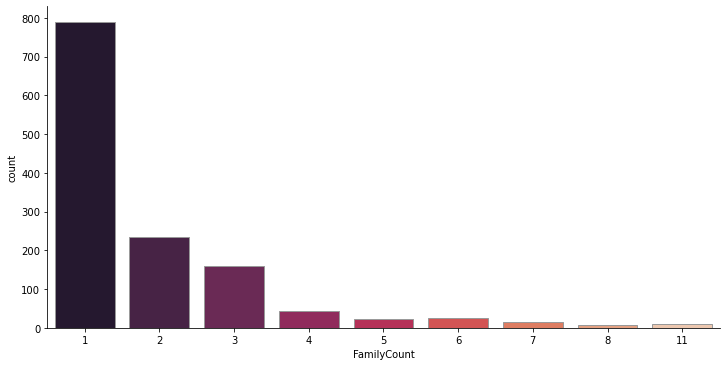

In [89]:
sns.catplot(x=data_raw['FamilyCount'], kind="count",
            palette="rocket", edgecolor=".6", aspect=2,
            data=data_raw)

<AxesSubplot:xlabel='FamilyCount', ylabel='count'>

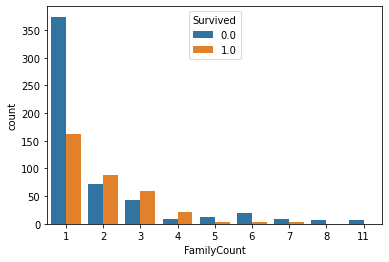

In [90]:
sns.countplot(x=data_raw['FamilyCount'],
            hue="Survived",
            data=data_raw)

It looks like travelling with a small family increased the chances of survival.

In [91]:
discrete.append('FamilyCount')

#### MOTHER-CHILD

I will create a column that holds the last name of the passenger when the passenger is either a mother or a young (younger than 11) child. Based on this column, I will check how the group as a whole did on surviving the disaster. 

In [92]:
data_raw['LastName'] = data_raw.apply(lambda row: row.Name.partition(",")[0], axis=1)

In [93]:
data_raw.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeHelperColumn,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,Title,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,Deck,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute,Age (box-cox),AgeImpute (box-cox),FamilyCount,LastName
0,0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,2.399674,22.0,13.219923,13.803786,2,Braund
1,1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,0,1,0,0,0,Mrs.,0,0,0,0,1,0,0,C,0,0,1,0,0,0,0,0,0,6.539036,38.0,21.015717,22.155164,2,Cumings
2,2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,1,1,0,0,0,0,1,Miss.,0,0,1,0,0,0,0,U,0,0,0,0,0,0,0,0,1,2.529854,26.0,15.257660,15.977543,1,Heikkinen
3,3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,0,0,0,0,1,Mrs.,0,0,0,0,1,0,0,C,0,0,1,0,0,0,0,0,0,5.900956,35.0,19.617894,20.651225,2,Futrelle
4,4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,2.552966,35.0,19.617894,20.651225,1,Allen


In [94]:
data_raw['MotherChild'] = data_raw.apply(lambda row: row.LastName if row.Sex_female == 1 and row.Parch != 0 and row.Age > 18 else 
                                         (row.LastName if row.Age < 9 and row.Parch != 0 else ''), axis=1)

In [95]:
ListMotherChild = data_raw['MotherChild'].tolist()

In [96]:
ListMotherChild

['',
 '',
 '',
 '',
 '',
 '',
 '',
 'Palsson',
 'Johnson',
 '',
 'Sandstrom',
 '',
 '',
 '',
 '',
 '',
 'Rice',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Palsson',
 'Asplund',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Laroche',
 '',
 '',
 '',
 '',
 '',
 '',
 'Panula',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'West',
 '',
 '',
 '',
 '',
 'Skoog',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Caldwell',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Fortune',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Doling',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Andersson',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Peter',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Newsom',
 '',
 '',
 '',
 'Boulos',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Panula',
 '',
 'Chibnall',
 'Skoog',
 '',
 '',
 '',
 'Rice',
 'Johns

In [97]:
counterMotherChild = Counter(ListMotherChild)

In [98]:
counterMotherChild

Counter({'': 1124,
         'Palsson': 5,
         'Johnson': 3,
         'Sandstrom': 3,
         'Rice': 5,
         'Asplund': 4,
         'Laroche': 3,
         'Panula': 4,
         'West': 3,
         'Skoog': 3,
         'Caldwell': 2,
         'Fortune': 4,
         'Doling': 1,
         'Andersson': 5,
         'Peter': 2,
         'Newsom': 1,
         'Boulos': 2,
         'Chibnall': 1,
         'Sage': 5,
         'Becker': 3,
         'Kink-Heilmann': 2,
         'Navratil': 2,
         'Strom': 2,
         'Lefebre': 4,
         'Collyer': 2,
         'Hamalainen': 2,
         'Rosblom': 2,
         'Touma': 2,
         'Parrish': 1,
         'Graham': 1,
         'Mellinger': 1,
         'Abbott': 1,
         'Allison': 3,
         'Baxter': 1,
         'Lahtinen': 1,
         'Wick': 2,
         'Spedden': 2,
         'Goldsmith': 1,
         'Coutts': 2,
         'Bowerman': 1,
         'Barbara': 1,
         'Nakid': 2,
         'Goodwin': 2,
         'Richards': 3,


- Created a new copy of the data, called "data"  and reset the index.
- Created a column CountMomCh, in here, the size of the group (mothers with children) will be saved, 0 when a person does not belong to a group at all
- two more additional columns. One CountSurvived. In here, I count the survivors within the group. One CountNanSurvived, in here I count the people in the group of whom we do not know 

In [99]:
data = data_raw

In [100]:
data = data.reset_index()

In [101]:
data['CountMomCh'] = 0

In [102]:
data['CountMomCh'] = data.apply(lambda row: counterMotherChild[row.MotherChild], axis=1)

In [103]:
data.groupby(['CountMomCh'])['Sex'].count()

CountMomCh
1         40
2         66
3         39
4         20
5         20
1124    1124
Name: Sex, dtype: int64

In [104]:
data['CountMomChSurvived'] = 0

In [105]:
data['countSurvived'] = 0
data['countNanSurvived'] = 0

def mommie(ListMotherChild):
    for i in range(len(ListMotherChild)-1):
        print(i)
        count = 0
        countNan = 0
        listIndex = []
        if data['CountMomCh'].loc[i] != 1124:
            
            if data.loc[i, 'Survived'] > -1:
                count += data.loc[i, 'Survived']
                listIndex.append(i)
                
                for j in range(len(ListMotherChild)-1):
                    
                    if (i != j)  and (ListMotherChild[i] == ListMotherChild[j]):
                        if data.loc[j, 'Survived'] > -1:
                            count += data.loc[j, 'Survived']
                            listIndex.append(j)
                        else:
                            countNan += 1
                            listIndex.append(j)
                        
            else:
                countNan += 1
                listIndex.append(i)
                
                for j in range(len(ListMotherChild)-1):

                    if (i != j)  and (ListMotherChild[i] == ListMotherChild[j]):
                        if data.loc[j, 'Survived'] > -1:
                            count += data.loc[j, 'Survived']
                            listIndex.append(j)
                        else:
                            countNan += 1
                            listIndex.append(j)
        
            for k in listIndex:
                print(i, k, count, countNan)
                data.loc[k, 'countSurvived'] = count
                data.loc[k, 'countNanSurvived'] = countNan
            

In [106]:
mommie(ListMotherChild)

0
1
2
3
4
5
6
7
7 7 0.0 1
7 24 0.0 1
7 374 0.0 1
7 567 0.0 1
7 1280 0.0 1
8
8 8 3.0 0
8 172 3.0 0
8 869 3.0 0
9
10
10 10 2.0 1
10 394 2.0 1
10 1008 2.0 1
11
12
13
14
15
16
16 16 0.0 0
16 171 0.0 0
16 278 0.0 0
16 787 0.0 0
16 885 0.0 0
17
18
19
20
21
22
23
24
24 24 0.0 1
24 7 0.0 1
24 374 0.0 1
24 567 0.0 1
24 1280 0.0 1
25
25 25 3.0 1
25 233 3.0 1
25 261 3.0 1
25 1270 3.0 1
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
43 43 2.0 1
43 608 2.0 1
43 1187 2.0 1
44
45
46
47
48
49
50
50 50 0.0 0
50 164 0.0 0
50 638 0.0 0
50 824 0.0 0
51
52
53
54
55
56
57
58
58 58 2.0 1
58 472 2.0 1
58 1141 2.0 1
59
60
61
62
63
63 63 0.0 0
63 167 0.0 0
63 642 0.0 0
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
78 78 2.0 0
78 323 2.0 0
79
80
81
82
83
84
85
86
87
88
88 88 2.0 2
88 341 2.0 2
88 944 2.0 2
88 960 2.0 2
89
90
91
92
93
94
95
96
97
98
98 98 1.0 0
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
119 119 0.0 1
119 610 0.0 1
119 813 0.0 1
119 850 0.0 1
119 1105 

It looks like the chances are that either the entire group survives, or all of them die. I see one case in which a mother and three of her children survive but one son, the oldest dies. This means that my age threshold for kids might be a bit too high. I choose 11. Maybe a bit younger would be a better predictor.

I therefore went back and changed it to 9.

In [107]:
data.head(100)

,level_0,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeHelperColumn,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,Title,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,Deck,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute,Age (box-cox),AgeImpute (box-cox),FamilyCount,LastName,MotherChild,CountMomCh,CountMomChSurvived,countSurvived,countNanSurvived
0,0,0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,2.399674,22.000000,13.219923,13.803786,2,Braund,,1124,0,0.0,0
1,1,1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,0,1,0,0,0,Mrs.,0,0,0,0,1,0,0,C,0,0,1,0,0,0,0,0,0,6.539036,38.000000,21.015717,22.155164,2,Cumings,,1124,0,0.0,0
2,2,2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,1,1,0,0,0,0,1,Miss.,0,0,1,0,0,0,0,U,0,0,0,0,0,0,0,0,1,2.529854,26.000000,15.257660,15.977543,1,Heikkinen,,1124,0,0.0,0
3,3,3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,0,0,0,0,1,Mrs.,0,0,0,0,1,0,0,C,0,0,1,0,0,0,0,0,0,5.900956,35.000000,19.617894,20.651225,2,Futrelle,,1124,0,0.0,0
4,4,4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,2.552966,35.000000,19.617894,20.651225,1,Allen,,1124,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,95,96,0.0,3,"Shorney, Mr. Charles Joseph",male,28.0,0,0,374910,8.0500,U,S,0,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,2.552966,29.249945,16.251127,17.696406,1,Shorney,,1124,0,0.0,0
96,96,96,97,0.0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C,1,0,1,1,0,0,0,Mr.,0,0,0,1,0,0,0,A,1,0,0,0,0,0,0,0,0,5.036668,71.000000,35.193584,37.527434,1,Goldschmidt,,1124,0,0.0,0
97,97,97,98,1.0,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C,1,0,1,1,0,0,0,Mr.,0,0,0,1,0,0,0,D,0,0,0,1,0,0,0,0,0,6.279429,23.000000,13.736243,14.353864,2,Greenfield,,1124,0,0.0,0
98,98,98,99,1.0,2,"Doling, Mrs. John T (Ada Julia Bone)",female,34.0,0,1,231919,23.0000,U,S,1,1,0,0,0,0,1,Mrs.,0,0,0,0,1,0,0,U,0,0,0,0,0,0,0,0,1,4.269184,34.000000,19.146374,20.144488,2,Doling,Doling,1,0,1.0,0


In order to use this in a ml model, I will take two different routes. 
1. I will hash encode the MotherChild column
2. I will create an additional column, dummySurvived. This is for testing purposes. To see how the model will react. I will add a 1 to the column if the chances of the group surviving are high, a -1 if the chances of the group dying are high, and a 0 if the person does not belong to a mother-child group.
3. I will drop all additional columns that were created to get to this point: CountMomCh, CountMomChSurvived, CountSurvived, CountNanSurvived. I will keep LastName for a bit longer... it might still be useful to name other groups of people travelling together. 

In [108]:
data['dummySurvived'] = data.apply(lambda row: 1 if row.MotherChild != '' and ((row.countSurvived + row.countNanSurvived)/row.CountMomCh) > 0.5 else
                                   (-1 if row.MotherChild != '' and ((row.countSurvived + row.countNanSurvived)/row.CountMomCh) <= 0.5 else 0), axis=1)

In [109]:
del data['CountMomCh']
del data['CountMomChSurvived']
del data['countSurvived']
del data['countNanSurvived']

In [110]:
dataCopy = data.copy()

fg = FeatureHasher(n_features=3, input_type='string')
hashed_features = fg.fit_transform(data['MotherChild'])
hashed_features = hashed_features.toarray()

data = pd.concat([data, pd.DataFrame(hashed_features)], axis=1)

In [111]:
data.rename(columns = {0:'MC_0', 1:'MC_1',2:'MC_2'}, inplace = True)

In [112]:
del data['level_0']
del data['index']

#### OTHER POSSIBLE GROUPS THAT TRAVELLED TOGETHER

In [113]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeHelperColumn,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,Title,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,Deck,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute,Age (box-cox),AgeImpute (box-cox),FamilyCount,LastName,MotherChild,dummySurvived,MC_0,MC_1,MC_2
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,2.399674,22.0,13.219923,13.803786,2,Braund,,0,0.0,0.0,0.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,0,1,0,0,0,Mrs.,0,0,0,0,1,0,0,C,0,0,1,0,0,0,0,0,0,6.539036,38.0,21.015717,22.155164,2,Cumings,,0,0.0,0.0,0.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,1,1,0,0,0,0,1,Miss.,0,0,1,0,0,0,0,U,0,0,0,0,0,0,0,0,1,2.529854,26.0,15.257660,15.977543,1,Heikkinen,,0,0.0,0.0,0.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,0,0,0,0,1,Mrs.,0,0,0,0,1,0,0,C,0,0,1,0,0,0,0,0,0,5.900956,35.0,19.617894,20.651225,2,Futrelle,,0,0.0,0.0,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,0,0,U,0,0,0,0,0,0,0,0,1,2.552966,35.0,19.617894,20.651225,1,Allen,,0,0.0,0.0,0.0


What could be other indicators that two (or more) people travelled together?
- Last name
- Ticket number, is it the same, than it was probably purchased at the same time (check also Fare in that case)
- Cabin, although you can ofcourse stay in different Cabins and still travel together
- The chances that people traveled together but not departed at the same harbor seem slim. So this can be used to check if people truly travelled together.


For the Ticket and the Cabin columns, I will use a counter to see how often the values exist within the dataset. I will add this number to two new columns: TicketAmount, CabinAmount

In [114]:
TicketList = data['Ticket'].tolist()

In [115]:
counterTicketList = Counter(TicketList)
counterTicketList

Counter({'A/5 21171': 1,
         'PC 17599': 2,
         'STON/O2. 3101282': 1,
         '113803': 2,
         '373450': 1,
         '330877': 1,
         '17463': 2,
         '349909': 5,
         '347742': 3,
         '237736': 2,
         'PP 9549': 3,
         '113783': 1,
         'A/5. 2151': 1,
         '347082': 7,
         '350406': 1,
         '248706': 1,
         '382652': 6,
         '244373': 1,
         '345763': 2,
         '2649': 1,
         '239865': 2,
         '248698': 1,
         '330923': 1,
         '113788': 1,
         '347077': 7,
         '2631': 1,
         '19950': 6,
         '330959': 1,
         '349216': 1,
         'PC 17601': 1,
         'PC 17569': 3,
         '335677': 1,
         'C.A. 24579': 1,
         'PC 17604': 2,
         '113789': 2,
         '2677': 1,
         'A./5. 2152': 1,
         '345764': 2,
         '2651': 2,
         '7546': 1,
         '11668': 2,
         '349253': 1,
         'SC/Paris 2123': 4,
         '330958': 1,
     

In [116]:
data['TicketAmount'] = data.apply(lambda row: counterTicketList.get(row.Ticket, None), axis = 1)

In [117]:
data[['Ticket','TicketAmount']].head()

,Ticket,TicketAmount
0,A/5 21171,1
1,PC 17599,2
2,STON/O2. 3101282,1
3,113803,2
4,373450,1


In [118]:
CabinList = data['Cabin'].tolist()

In [119]:
counterCabinList = Counter(CabinList)
counterCabinList

Counter({'U': 1014,
         'C85': 2,
         'C123': 2,
         'E46': 2,
         'G6': 5,
         'C103': 1,
         'D56': 1,
         'A6': 1,
         'C23 C25 C27': 6,
         'B78': 2,
         'D33': 2,
         'B30': 1,
         'C52': 2,
         'B28': 2,
         'C83': 2,
         'F33': 4,
         'F G73': 2,
         'E31': 2,
         'A5': 1,
         'D10 D12': 2,
         'D26': 2,
         'C110': 1,
         'B58 B60': 3,
         'E101': 3,
         'F E69': 1,
         'D47': 1,
         'B86': 1,
         'F2': 4,
         'C2': 2,
         'E33': 2,
         'B19': 1,
         'A7': 1,
         'C49': 1,
         'F4': 4,
         'A32': 1,
         'B4': 1,
         'B80': 1,
         'A31': 1,
         'D36': 2,
         'D15': 2,
         'C93': 2,
         'C78': 4,
         'D35': 2,
         'C87': 1,
         'B77': 2,
         'E67': 2,
         'B94': 1,
         'C125': 2,
         'C99': 1,
         'C118': 1,
         'D7': 1,
         'A19

In [120]:
data['CabinAmount'] = data.apply(lambda row: counterCabinList.get(row.Cabin, None), axis = 1)

In [121]:
data['CabinAmount'] = data.apply(lambda row: 1 if row.CabinAmount == 1014 else row.CabinAmount, axis = 1)

In [122]:
data[['Cabin','CabinAmount']].head()

,Cabin,CabinAmount
0,U,1
1,C85,2
2,U,1
3,C123,2
4,U,1


In [123]:
data[['Pclass','FamilyCount', 'Cabin','Ticket','CabinAmount','TicketAmount']].head(500)

,Pclass,FamilyCount,Cabin,Ticket,CabinAmount,TicketAmount
0,3,2,U,A/5 21171,1,1
1,1,2,C85,PC 17599,2,2
2,3,1,U,STON/O2. 3101282,1,1
3,1,2,C123,113803,2,2
4,3,1,U,373450,1,1
...,...,...,...,...,...,...
495,3,1,U,2627,1,2
496,1,2,D20,36947,2,2
497,3,1,U,C.A. 6212,1,2
498,1,4,C22 C26,113781,4,6


Let's see what kind of situations we encounter in the data:
- CabinAmount = TicketAmount >>> Probably a good indication of the group
- CabinAmount < TicketAmount, with Cabin U = unknown >>> TicketAmount is probs the better indication of the group
- CabinAmount > TicketAmount, with Cabin != U & Pclass = 3 >>> Probably the cabin is shared with other people. 
- CabinAmount < TicketAmount, with Cabin B/D, class 1 >>> Probably travelling together based on ticket but two different cabins.

All together, the ticketAmount seems to be the better predicter of a group travelling together. 


In [124]:
data['groupSolo'] = data.apply(lambda row: "solo" if row.TicketAmount == 1 else 
                              ("duo" if row.TicketAmount == 2 else
                              ("trio" if row.TicketAmount == 3 else
                              ("quatro" if row.TicketAmount == 4  else "large"))), axis = 1)

In [125]:
data['groupId'] = data.apply(lambda row: row.Ticket if row.TicketAmount > 1 else '', axis = 1)

In [126]:
dataCopy = data.copy()

fg = FeatureHasher(n_features=4, input_type='string')
hashed_features = fg.fit_transform(data['groupId'])
hashed_features = hashed_features.toarray()

data = pd.concat([data, pd.DataFrame(hashed_features)], axis=1)

In [127]:
data.rename(columns = {0:'GrId_0', 1:'GrId_1',2:'GrId_2', 3: 'GrId_3'}, inplace = True)

In [128]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeHelperColumn,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,Title,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,...,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute,Age (box-cox),AgeImpute (box-cox),FamilyCount,LastName,MotherChild,dummySurvived,MC_0,MC_1,MC_2,TicketAmount,CabinAmount,groupSolo,groupId,GrId_0,GrId_1,GrId_2,GrId_3
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,...,0,0,0,0,0,1,2.399674,22.0,13.219923,13.803786,2,Braund,,0,0.0,0.0,0.0,1,1,solo,,0.0,0.0,0.0,0.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,0,1,0,0,0,Mrs.,0,0,0,0,1,...,0,0,0,0,0,0,6.539036,38.0,21.015717,22.155164,2,Cumings,,0,0.0,0.0,0.0,2,2,duo,PC 17599,3.0,-1.0,0.0,0.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,1,1,0,0,0,0,1,Miss.,0,0,1,0,0,...,0,0,0,0,0,1,2.529854,26.0,15.257660,15.977543,1,Heikkinen,,0,0.0,0.0,0.0,1,1,solo,,0.0,0.0,0.0,0.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,0,0,0,0,1,Mrs.,0,0,0,0,1,...,0,0,0,0,0,0,5.900956,35.0,19.617894,20.651225,2,Futrelle,,0,0.0,0.0,0.0,2,2,duo,113803,2.0,-4.0,0.0,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,1,0,1,0,0,0,1,Mr.,0,0,0,1,0,...,0,0,0,0,0,1,2.552966,35.0,19.617894,20.651225,1,Allen,,0,0.0,0.0,0.0,1,1,solo,,0.0,0.0,0.0,0.0


In [129]:
dataCopy = data.copy()

## Let's create a dataframe with useful columns

In [130]:
data.columns.tolist()

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'AgeHelperColumn',
 'Sex_female',
 'Sex_male',
 'Emb_C',
 'Emb_NoEmbarked',
 'Emb_Q',
 'Emb_S',
 'Title',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'T_NoTitle',
 'T_Rev.',
 'Deck',
 'D_A',
 'D_B',
 'D_C',
 'D_D',
 'D_E',
 'D_F',
 'D_G',
 'D_T',
 'D_U',
 'FarePlus (box-cox)',
 'AgeImpute',
 'Age (box-cox)',
 'AgeImpute (box-cox)',
 'FamilyCount',
 'LastName',
 'MotherChild',
 'dummySurvived',
 'MC_0',
 'MC_1',
 'MC_2',
 'TicketAmount',
 'CabinAmount',
 'groupSolo',
 'groupId',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']

In [131]:
data_model = data[['PassengerId',
 'Survived',
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Sex_female',
 'Sex_male',
 'Emb_C',
 'Emb_NoEmbarked',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'T_NoTitle',
 'T_Rev.',
 'D_A',
 'D_B',
 'D_C',
 'D_D',
 'D_E',
 'D_F',
 'D_G',
 'D_T',
 'D_U',
 'FarePlus (box-cox)',
 'AgeImpute',
 'Age (box-cox)',
 'AgeImpute (box-cox)',
 'FamilyCount',
 'dummySurvived',
 'MC_0',
 'MC_1',
 'MC_2',
 'TicketAmount',
 'CabinAmount',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']]

In [132]:
data_model.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute,Age (box-cox),AgeImpute (box-cox),FamilyCount,dummySurvived,MC_0,MC_1,MC_2,TicketAmount,CabinAmount,GrId_0,GrId_1,GrId_2,GrId_3
0,1,0.0,3,22.0,1,0,7.2500,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.399674,22.0,13.219923,13.803786,2,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
1,2,1.0,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,6.539036,38.0,21.015717,22.155164,2,0,0.0,0.0,0.0,2,2,3.0,-1.0,0.0,0.0
2,3,1.0,3,26.0,0,0,7.9250,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2.529854,26.0,15.257660,15.977543,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
3,4,1.0,1,35.0,1,0,53.1000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,5.900956,35.0,19.617894,20.651225,2,0,0.0,0.0,0.0,2,2,2.0,-4.0,0.0,0.0
4,5,0.0,3,35.0,0,0,8.0500,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.552966,35.0,19.617894,20.651225,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0


In [133]:
continuous

['Age', 'Fare', 'FarePlus (box-cox)', 'Age (box-cox)', 'AgeImpute (box-cox)']

In [134]:
continuous.append('AgeImpute')

In [135]:
discrete

['PassengerId', 'Survived', 'SibSp', 'Parch', 'FamilyCount']

In [136]:
discrete.remove('Survived')

In [137]:
discrete.append('FamilyCount')
discrete.append('dummySurvived')
discrete.append('MC_0')
discrete.append('MC_1')
discrete.append('MC_2')
discrete.append('TicketAmount')
discrete.append('CabinAmount')
discrete.append('GrId_0')
discrete.append('GrId_1')
discrete.append('GrId_2')
discrete.append('GrId_3')

In [138]:
ordinal

['Pclass']

In [139]:
nominal

['Name',
 'Sex',
 'Ticket',
 'Cabin',
 'Embarked',
 'Sex_female',
 'Sex_male',
 'Emb_C',
 'Emb_NoEmbarked',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'T_NoTitle',
 'T_Rev.',
 'Deck',
 'D_A',
 'D_B',
 'D_C',
 'D_D',
 'D_E',
 'D_F',
 'D_G',
 'D_T',
 'D_U']

In [140]:
nominal.remove('Ticket')
nominal.remove('Cabin')
nominal.remove('Embarked')
nominal.remove('Deck')
nominal.remove('Name')
nominal.remove('Sex')

In [141]:
dependent = ['Survived']

## Let's take a look at correlation

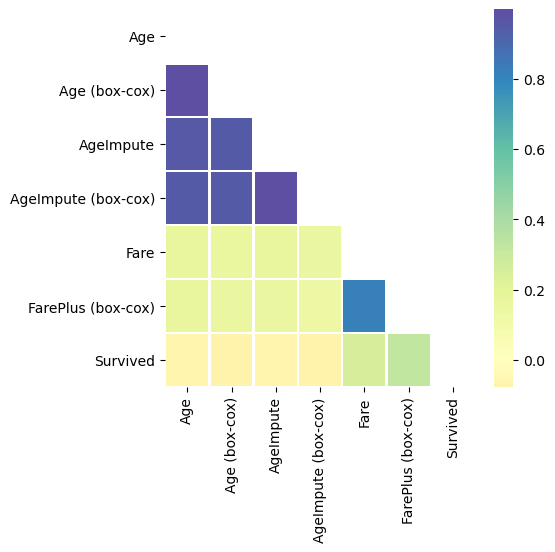

In [142]:
continuous_correlation = sorted(continuous) + dependent
correlation = data_model[continuous_correlation].corr(method="pearson")
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig = plt.figure(figsize=(5,5), dpi=100, facecolor = 'w', edgecolor="k")
figure = sns.heatmap(correlation, mask=mask, cmap= "Spectral", center=0, linewidths=1, fmt=".2f")

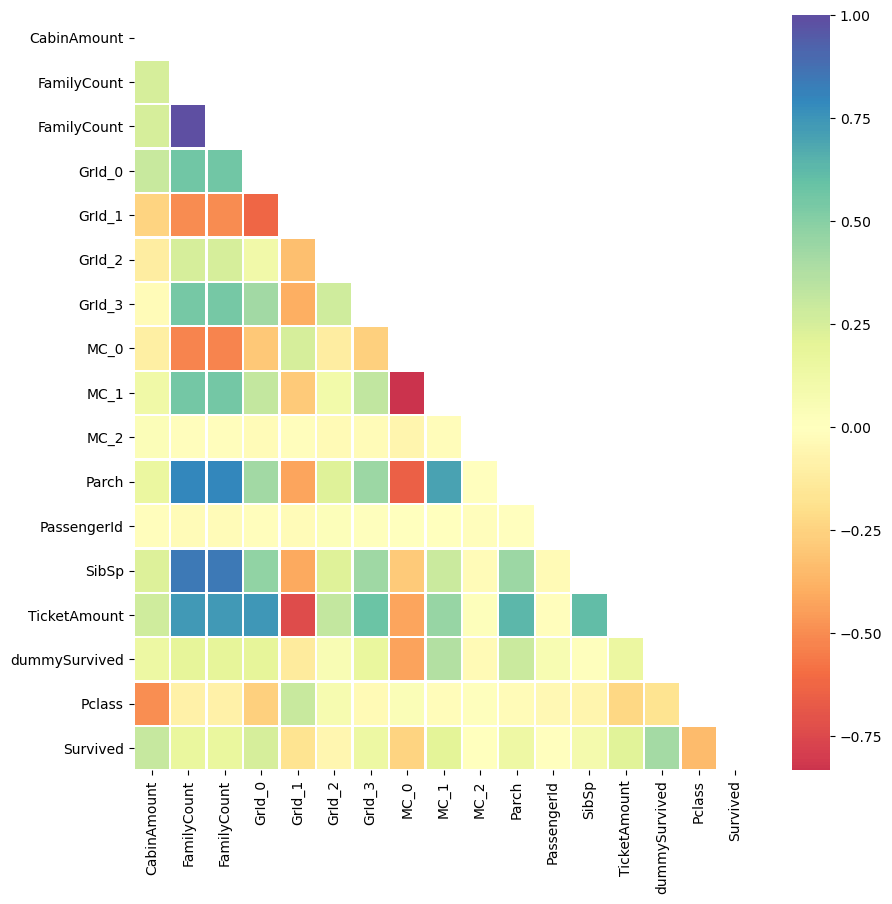

In [143]:
correlationDO = sorted(discrete) + sorted(ordinal) + dependent
correlation = data_model[correlationDO].corr(method="spearman")
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig = plt.figure(figsize=(10,10), dpi=100, facecolor = 'w', edgecolor="k")
figure = sns.heatmap(correlation, mask=mask, cmap= "Spectral", center=0, linewidths=1, fmt=".2f")

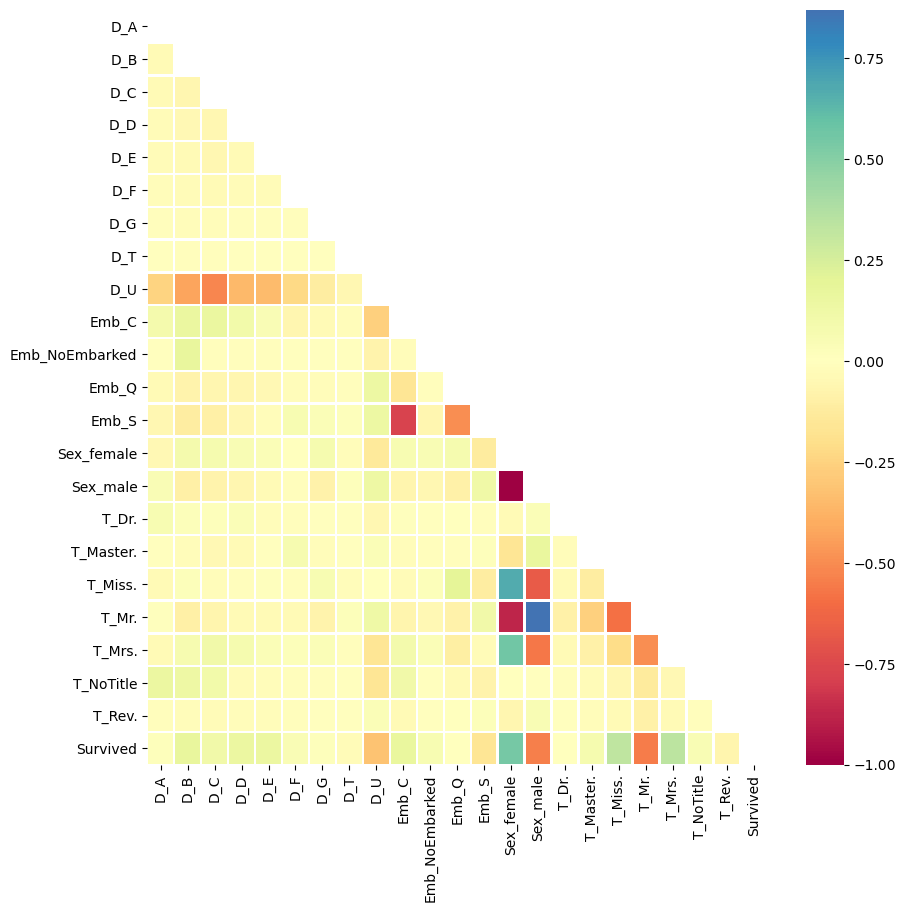

In [144]:
correlationDO = sorted(nominal) + dependent
correlation = data_model[correlationDO].corr(method="spearman")
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig = plt.figure(figsize=(10,10), dpi=100, facecolor = 'w', edgecolor="k")
figure = sns.heatmap(correlation, mask=mask, cmap= "Spectral", center=0, linewidths=1, fmt=".2f")

In [145]:
data = data_model.set_index('PassengerId')

In [146]:
data_train = data.loc[(data['Survived'].notna())]
data_toPredict = data.loc[(data['Survived'].isna())]

In [147]:
del data_toPredict['Survived']

In [148]:
data_toPredict.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute,Age (box-cox),AgeImpute (box-cox),FamilyCount,dummySurvived,MC_0,MC_1,MC_2,TicketAmount,CabinAmount,GrId_0,GrId_1,GrId_2,GrId_3
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
892,3,34.5,0,0,7.8292,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.511941,34.5,19.382497,20.398209,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
893,3,47.0,1,0,7.0000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.348954,47.0,25.077515,26.538665,2,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
894,2,62.0,0,0,9.6875,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.831631,62.0,31.501149,33.505965,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
895,3,27.0,0,0,8.6625,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.662169,27.0,15.756347,16.510608,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
896,3,22.0,1,1,12.2875,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,3.203933,22.0,13.219923,13.803786,3,1,-3.0,4.0,-1.0,2,1,1.0,-3.0,0.0,1.0


In [149]:
data_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute,Age (box-cox),AgeImpute (box-cox),FamilyCount,dummySurvived,MC_0,MC_1,MC_2,TicketAmount,CabinAmount,GrId_0,GrId_1,GrId_2,GrId_3
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,22.0,1,0,7.2500,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.399674,22.0,13.219923,13.803786,2,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
2,1.0,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,6.539036,38.0,21.015717,22.155164,2,0,0.0,0.0,0.0,2,2,3.0,-1.0,0.0,0.0
3,1.0,3,26.0,0,0,7.9250,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2.529854,26.0,15.257660,15.977543,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
4,1.0,1,35.0,1,0,53.1000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,5.900956,35.0,19.617894,20.651225,2,0,0.0,0.0,0.0,2,2,2.0,-4.0,0.0,0.0
5,0.0,3,35.0,0,0,8.0500,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.552966,35.0,19.617894,20.651225,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0


In [150]:
x1 = data_train.drop(columns=["Survived"]).values
y1 = data_train["Survived"].values

# Titanic Project - PART 3 - Model

In this section I will build some models. I will start with Logistic Regression and will than continue with RandomForest. 
For the logistic regression I will first use all features and will after use a subset to precent overfitting and multicollinearity. 

##### LogisticRegression 1

In [151]:
lr = LogisticRegression()

In [152]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, train_size=0.6, test_size=0.4, random_state=100)

In [153]:
scaler = StandardScaler()
x1_train = scaler.fit_transform(x1_train)
x1_test = scaler.transform(x1_test)

In [154]:
lr.fit(x1_train, y1_train)

LogisticRegression()

In [155]:
print(lr.score(x1_train, y1_train))

0.8801498127340824


In [156]:
print(lr.score(x1_test, y1_test))

0.8095238095238095


Let's fit the model on the entire train set. In order to be able to get the best model with this data. After training the model, I will make a prediction and give the first results a try in Kaggle.

In [157]:
x1 = scaler.fit_transform(x1)

In [158]:
lr.fit(x1, y1)

LogisticRegression()

In [159]:
print(lr.score(x1, y1))

0.8540965207631874


In [160]:
data_toPredict = scaler.fit_transform(data_toPredict)

In [161]:
Survived = lr.predict(data_toPredict)

In [162]:
SurvivedList = []

In [163]:
for x in Survived:
    SurvivedList.append(int(x))

In [164]:
submission = data.loc[(data['Survived'].isna())]
submission.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute,Age (box-cox),AgeImpute (box-cox),FamilyCount,dummySurvived,MC_0,MC_1,MC_2,TicketAmount,CabinAmount,GrId_0,GrId_1,GrId_2,GrId_3
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
892,NaN,3,34.5,0,0,7.8292,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.511941,34.5,19.382497,20.398209,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
893,NaN,3,47.0,1,0,7.0000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.348954,47.0,25.077515,26.538665,2,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
894,NaN,2,62.0,0,0,9.6875,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.831631,62.0,31.501149,33.505965,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
895,NaN,3,27.0,0,0,8.6625,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.662169,27.0,15.756347,16.510608,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
896,NaN,3,22.0,1,1,12.2875,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,3.203933,22.0,13.219923,13.803786,3,1,-3.0,4.0,-1.0,2,1,1.0,-3.0,0.0,1.0


In [165]:
del submission['Survived']

In [166]:
submission['Survived'] = np.array(SurvivedList)

<ipython-input-166-0af8da9b35bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Survived'] = np.array(SurvivedList)


In [167]:
submission = submission[['Survived']]

In [168]:
submission.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [169]:
submission.to_csv("C:/Users/meykevandenbos/Documents/Meyke persoonlijk/Techionista/Titanic/prediction_submission28032121.csv")

##### LogisticRegression 2

In [170]:
data_train2 = data.loc[(data['Survived'].notna())]
data_toPredict2 = data.loc[(data['Survived'].isna())]

In [171]:
data_train2.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute,Age (box-cox),AgeImpute (box-cox),FamilyCount,dummySurvived,MC_0,MC_1,MC_2,TicketAmount,CabinAmount,GrId_0,GrId_1,GrId_2,GrId_3
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,22.0,1,0,7.2500,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.399674,22.0,13.219923,13.803786,2,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
2,1.0,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,6.539036,38.0,21.015717,22.155164,2,0,0.0,0.0,0.0,2,2,3.0,-1.0,0.0,0.0
3,1.0,3,26.0,0,0,7.9250,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2.529854,26.0,15.257660,15.977543,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
4,1.0,1,35.0,1,0,53.1000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,5.900956,35.0,19.617894,20.651225,2,0,0.0,0.0,0.0,2,2,2.0,-4.0,0.0,0.0
5,0.0,3,35.0,0,0,8.0500,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.552966,35.0,19.617894,20.651225,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0


In [172]:
data_train2.columns.tolist()

['Survived',
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Sex_female',
 'Sex_male',
 'Emb_C',
 'Emb_NoEmbarked',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'T_NoTitle',
 'T_Rev.',
 'D_A',
 'D_B',
 'D_C',
 'D_D',
 'D_E',
 'D_F',
 'D_G',
 'D_T',
 'D_U',
 'FarePlus (box-cox)',
 'AgeImpute',
 'Age (box-cox)',
 'AgeImpute (box-cox)',
 'FamilyCount',
 'dummySurvived',
 'MC_0',
 'MC_1',
 'MC_2',
 'TicketAmount',
 'CabinAmount',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']

In [173]:
data_train2 = data_train2[['Survived',
 'Pclass',
 'SibSp',
 'Parch',
 'Sex_female',
 'Emb_NoEmbarked',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'T_NoTitle',
 'T_Rev.',
 'D_B',
 'D_C',
 'D_D',
 'D_E',
 'D_F',
 'D_G',
 'D_T',
 'D_U',
 'FarePlus (box-cox)',
 'AgeImpute (box-cox)',
 'dummySurvived',
 'MC_0',
 'MC_1',
 'MC_2',
 'TicketAmount',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']]

In [174]:
data_train2.head()

,Survived,Pclass,SibSp,Parch,Sex_female,Emb_NoEmbarked,Emb_Q,Emb_S,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute (box-cox),dummySurvived,MC_0,MC_1,MC_2,TicketAmount,GrId_0,GrId_1,GrId_2,GrId_3
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.399674,13.803786,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
2,1.0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,6.539036,22.155164,0,0.0,0.0,0.0,2,3.0,-1.0,0.0,0.0
3,1.0,3,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.529854,15.977543,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
4,1.0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,5.900956,20.651225,0,0.0,0.0,0.0,2,2.0,-4.0,0.0,0.0
5,0.0,3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.552966,20.651225,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0


In [175]:
data_toPredict2 = data_toPredict2[['Survived',
 'Pclass',
 'SibSp',
 'Parch',
 'Sex_female',
 'Emb_NoEmbarked',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'T_NoTitle',
 'T_Rev.',
 'D_B',
 'D_C',
 'D_D',
 'D_E',
 'D_F',
 'D_G',
 'D_T',
 'D_U',
 'FarePlus (box-cox)',
 'AgeImpute (box-cox)',
 'dummySurvived',
 'MC_0',
 'MC_1',
 'MC_2',
 'TicketAmount',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']]

In [176]:
del data_toPredict2['Survived']

In [177]:
x1 = data_train2.drop(columns=["Survived"]).values
y1 = data_train2["Survived"].values

In [178]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, train_size=0.8, test_size=0.2, random_state=100)

In [179]:
x1_train = scaler.fit_transform(x1_train)
x1_test = scaler.transform(x1_test)

In [180]:
lr.fit(x1_train, y1_train)

LogisticRegression()

In [181]:
print(lr.score(x1_train, y1_train))

0.8539325842696629


In [182]:
print(lr.score(x1_test, y1_test))

0.8491620111731844


In [183]:
x1 = scaler.fit_transform(x1)

In [184]:
lr.fit(x1, y1)
print(lr.score(x1, y1))

0.8529741863075196


In [185]:
data_toPredict2 = scaler.fit_transform(data_toPredict2)

In [186]:
Survived2 = lr.predict(data_toPredict2)

In [187]:
SurvivedList2 = []

In [188]:
for x in Survived2:
    SurvivedList2.append(int(x))

In [189]:
submission = data.loc[(data['Survived'].isna())]
submission.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute,Age (box-cox),AgeImpute (box-cox),FamilyCount,dummySurvived,MC_0,MC_1,MC_2,TicketAmount,CabinAmount,GrId_0,GrId_1,GrId_2,GrId_3
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
892,NaN,3,34.5,0,0,7.8292,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.511941,34.5,19.382497,20.398209,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
893,NaN,3,47.0,1,0,7.0000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.348954,47.0,25.077515,26.538665,2,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
894,NaN,2,62.0,0,0,9.6875,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.831631,62.0,31.501149,33.505965,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
895,NaN,3,27.0,0,0,8.6625,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.662169,27.0,15.756347,16.510608,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
896,NaN,3,22.0,1,1,12.2875,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,3.203933,22.0,13.219923,13.803786,3,1,-3.0,4.0,-1.0,2,1,1.0,-3.0,0.0,1.0


In [190]:
del submission['Survived']

In [191]:
submission['Survived'] = np.array(SurvivedList2)

<ipython-input-191-2b2131caa8df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Survived'] = np.array(SurvivedList2)


In [192]:
submission = submission[['Survived']]

In [193]:
submission.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [194]:
submission.to_csv("C:/Users/meykevandenbos/Documents/Meyke persoonlijk/Techionista/Titanic/prediction_submission28032121-2.csv")

##### RandomForest 1

In [223]:
data_train3 = data.loc[(data['Survived'].notna())]
data_toPredict3 = data.loc[(data['Survived'].isna())]

In [224]:
del data_toPredict3['Survived']

In [225]:
x1 = data_train3.drop(columns=["Survived"]).values
y1 = data_train3["Survived"].values

In [226]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, train_size=0.8, test_size=0.2, random_state=1)

In [215]:
random_state = 4
modelRF = RandomForestClassifier(random_state=4)
parameters = {"n_estimators": [100,125,150,175],
             "max_depth": [3,4,5,6,7]}

kfold = KFold(n_splits=3, random_state=random_state, shuffle = True)
cv = GridSearchCV(modelRF, param_grid = parameters, cv=kfold, scoring = "accuracy")
cv.fit(x1_train, y1_train)

y1_predict = cv.predict(x1_test)
y1_pred_proba = cv.predict_proba(x1_test)[:,1]

print("Accuracy train: {}".format(cv.score(x1_train, y1_train)))
print("Accuracy test: {}".format(cv.score(x1_test, y1_test)))
print("AUC score: {}".format(roc_auc_score(y1_test, y1_pred_proba)))
print("Tuned Model Parameters: {}".format(cv.best_params_))
print(confusion_matrix(y1_test, y1_predict))
print(classification_report(y1_test, y1_predict))

Accuracy train: 0.8497191011235955
Accuracy test: 0.8044692737430168
AUC score: 0.8597828896355649
Tuned Model Parameters: {'max_depth': 4, 'n_estimators': 150}
[[95 11]
 [24 49]]
              precision    recall  f1-score   support

         0.0       0.80      0.90      0.84       106
         1.0       0.82      0.67      0.74        73

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179



In [227]:
forest = RandomForestClassifier(n_estimators = 150, max_depth=4, random_state=4)
forest.fit(x1, y1)

print(forest.score(x1, y1))

0.8496071829405163


In [228]:
RandomForestPrediction = forest.predict(data_toPredict3)
RandomForestPrediction = [int(x) for x in RandomForestPrediction]
print(RandomForestPrediction)
print(type(RandomForestPrediction[0]))

[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 

In [229]:
data_toPredict3['Survived'] = RandomForestPrediction

<ipython-input-229-a70c9387e827>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_toPredict3['Survived'] = RandomForestPrediction


In [234]:
data_toPredict3.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute,Age (box-cox),AgeImpute (box-cox),FamilyCount,dummySurvived,MC_0,MC_1,MC_2,TicketAmount,CabinAmount,GrId_0,GrId_1,GrId_2,GrId_3,Survived
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
892,3,34.5,0,0,7.8292,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.511941,34.5,19.382497,20.398209,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0
893,3,47.0,1,0,7.0000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.348954,47.0,25.077515,26.538665,2,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,1
894,2,62.0,0,0,9.6875,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.831631,62.0,31.501149,33.505965,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0
895,3,27.0,0,0,8.6625,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.662169,27.0,15.756347,16.510608,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0
896,3,22.0,1,1,12.2875,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,3.203933,22.0,13.219923,13.803786,3,1,-3.0,4.0,-1.0,2,1,1.0,-3.0,0.0,1.0,1


In [231]:
submission = data_toPredict3[['Survived']]

In [232]:
submission.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [233]:
submission.to_csv("C:/Users/meykevandenbos/Documents/Meyke persoonlijk/Techionista/Titanic/prediction_submission29032121-1.csv")

##### RandomForest 2

In [253]:
data_train4 = data.loc[(data['Survived'].notna())]
data_toPredict4 = data.loc[(data['Survived'].isna())]

In [254]:
data_train4 = data_train4[['Survived',
 'Pclass',
 'SibSp',
 'Parch',
 'Sex_female',
 'Emb_NoEmbarked',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'T_NoTitle',
 'T_Rev.',
 'D_B',
 'D_C',
 'D_D',
 'D_E',
 'D_F',
 'D_G',
 'D_T',
 'D_U',
 'FarePlus (box-cox)',
 'AgeImpute (box-cox)',
 'dummySurvived',
 'MC_0',
 'MC_1',
 'MC_2',
 'TicketAmount',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']]

In [255]:
data_train4.head()

,Survived,Pclass,SibSp,Parch,Sex_female,Emb_NoEmbarked,Emb_Q,Emb_S,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute (box-cox),dummySurvived,MC_0,MC_1,MC_2,TicketAmount,GrId_0,GrId_1,GrId_2,GrId_3
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.399674,13.803786,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
2,1.0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,6.539036,22.155164,0,0.0,0.0,0.0,2,3.0,-1.0,0.0,0.0
3,1.0,3,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.529854,15.977543,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
4,1.0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,5.900956,20.651225,0,0.0,0.0,0.0,2,2.0,-4.0,0.0,0.0
5,0.0,3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.552966,20.651225,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0


In [256]:
data_toPredict4 = data_toPredict4[['Survived',
 'Pclass',
 'SibSp',
 'Parch',
 'Sex_female',
 'Emb_NoEmbarked',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'T_NoTitle',
 'T_Rev.',
 'D_B',
 'D_C',
 'D_D',
 'D_E',
 'D_F',
 'D_G',
 'D_T',
 'D_U',
 'FarePlus (box-cox)',
 'AgeImpute (box-cox)',
 'MC_0',
 'MC_1',
 'MC_2',
 'TicketAmount',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']]

In [257]:
del data_toPredict4['Survived']

In [258]:
x1 = data_train4.drop(columns=["Survived"]).values
y1 = data_train4["Survived"].values

In [259]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, train_size=0.8, test_size=0.2, random_state=1)

In [261]:
random_state = 4
modelRF = RandomForestClassifier(random_state=4)
parameters = {"n_estimators": [200,1000,2000],
             "max_depth": [3,4,5,6,7],
             "max_features": ["auto", "log2", None]}

kfold = KFold(n_splits=3, random_state=random_state, shuffle = True)
cv = GridSearchCV(modelRF, param_grid = parameters, cv=kfold, scoring = "accuracy")
cv.fit(x1_train, y1_train)

y1_predict = cv.predict(x1_test)
y1_pred_proba = cv.predict_proba(x1_test)[:,1]

print("Accuracy train: {}".format(cv.score(x1_train, y1_train)))
print("Accuracy test: {}".format(cv.score(x1_test, y1_test)))
print("AUC score: {}".format(roc_auc_score(y1_test, y1_pred_proba)))
print("Tuned Model Parameters: {}".format(cv.best_params_))
print(confusion_matrix(y1_test, y1_predict))
print(classification_report(y1_test, y1_predict))

Accuracy train: 0.8497191011235955
Accuracy test: 0.8212290502793296
AUC score: 0.8606228999741535
Tuned Model Parameters: {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 1000}
[[96 10]
 [22 51]]
              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86       106
         1.0       0.84      0.70      0.76        73

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



In [285]:
names = data_toPredict4.columns.tolist()

0.8451178451178452
Sex_female             0.199499
T_Mr.                  0.179438
dummySurvived          0.130926
Pclass                 0.069374
FarePlus (box-cox)     0.061844
T_Miss.                0.058203
T_Mrs.                 0.054571
D_U                    0.044544
TicketAmount           0.037125
AgeImpute (box-cox)    0.022344
MC_0                   0.020567
SibSp                  0.017933
MC_1                   0.015723
GrId_0                 0.015027
GrId_1                 0.012243
Parch                  0.010264
MC_2                   0.008244
Emb_S                  0.007599
D_E                    0.006896
D_B                    0.005264
T_Master.              0.004011
D_D                    0.003838
GrId_3                 0.003738
GrId_2                 0.003145
D_C                    0.002334
Emb_Q                  0.002122
T_Rev.                 0.001080
T_NoTitle              0.000622
T_Dr.                  0.000500
D_F                    0.000479
D_G                  

No handles with labels found to put in legend.


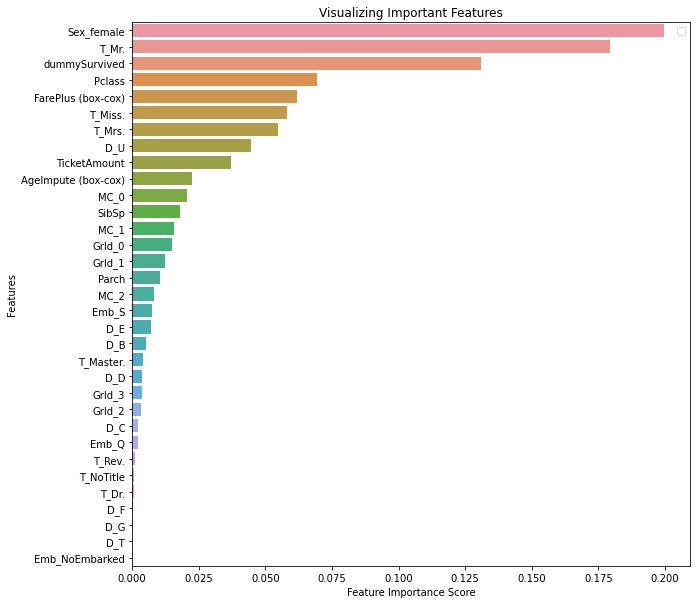

In [289]:
forest = RandomForestClassifier(n_estimators = 1000, max_depth=4, random_state=4)
forest.fit(x1, y1)

print(forest.score(x1, y1))

feature_imp = pd.Series(forest.feature_importances_,index=names).sort_values(ascending=False)
print(feature_imp)

%matplotlib inline
# Creating a bar plot
plt.figure(figsize=(10,10))
plt.title("Feature importances")
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.legend()
plt.show()


In [246]:
RandomForestPrediction = forest.predict(data_toPredict4)
RandomForestPrediction = [int(x) for x in RandomForestPrediction]
print(RandomForestPrediction)
print(type(RandomForestPrediction[0]))

[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 

In [247]:
data_toPredict4['Survived'] = RandomForestPrediction

In [248]:
data_toPredict4.head()

,Pclass,SibSp,Parch,Sex_female,Emb_NoEmbarked,Emb_Q,Emb_S,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute (box-cox),dummySurvived,MC_0,MC_1,MC_2,TicketAmount,GrId_0,GrId_1,GrId_2,GrId_3,Survived
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
892,3,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.511941,20.398209,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0
893,3,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2.348954,26.538665,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1
894,2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.831631,33.505965,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0
895,3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.662169,16.510608,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0
896,3,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,3.203933,13.803786,1,-3.0,4.0,-1.0,2,1.0,-3.0,0.0,1.0,1


In [249]:
submission = data_toPredict4[['Survived']]

In [250]:
submission.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [251]:
submission.to_csv("C:/Users/meykevandenbos/Documents/Meyke persoonlijk/Techionista/Titanic/prediction_submission29032121-2.csv")

##### RandomForest 3 A and B

I will now test what happens to the model when I delete either the Dummyurvived feature, or the MC features.

In [305]:
data_train5 = data.loc[(data['Survived'].notna())]
data_toPredict5 = data.loc[(data['Survived'].isna())]

In [306]:
# First without DummySurvived
data_train5 = data_train5[['Survived',
 'Pclass',
 'SibSp',
 'Parch',
 'Sex_female',
 'Emb_NoEmbarked',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'T_NoTitle',
 'T_Rev.',
 'D_B',
 'D_C',
 'D_D',
 'D_E',
 'D_F',
 'D_G',
 'D_T',
 'D_U',
 'FarePlus (box-cox)',
 'AgeImpute (box-cox)',
 'MC_0',
 'MC_1',
 'MC_2',
 'TicketAmount',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']]

In [307]:
data_toPredict5 = data_toPredict5[['Pclass',
 'SibSp',
 'Parch',
 'Sex_female',
 'Emb_NoEmbarked',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'T_NoTitle',
 'T_Rev.',
 'D_B',
 'D_C',
 'D_D',
 'D_E',
 'D_F',
 'D_G',
 'D_T',
 'D_U',
 'FarePlus (box-cox)',
 'AgeImpute (box-cox)',
 'MC_0',
 'MC_1',
 'MC_2',
 'TicketAmount',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']]

In [308]:
x1 = data_train5.drop(columns=["Survived"]).values
y1 = data_train5["Survived"].values

In [309]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, train_size=0.8, test_size=0.2, random_state=1)

In [310]:
random_state = 4
modelRF = RandomForestClassifier(random_state=4)
parameters = {"n_estimators": [150,200,250,300,350],
             "max_depth": [4,5,6],
             "max_features": ["auto", "log2", None]}

kfold = KFold(n_splits=3, random_state=random_state, shuffle = True)
cv = GridSearchCV(modelRF, param_grid = parameters, cv=kfold, scoring = "accuracy")
cv.fit(x1_train, y1_train)

y1_predict = cv.predict(x1_test)
y1_pred_proba = cv.predict_proba(x1_test)[:,1]

print("Accuracy train: {}".format(cv.score(x1_train, y1_train)))
print("Accuracy test: {}".format(cv.score(x1_test, y1_test)))
print("AUC score: {}".format(roc_auc_score(y1_test, y1_pred_proba)))
print("Tuned Model Parameters: {}".format(cv.best_params_))
print(confusion_matrix(y1_test, y1_predict))
print(classification_report(y1_test, y1_predict))

Accuracy train: 0.851123595505618
Accuracy test: 0.8100558659217877
AUC score: 0.8578444042388214
Tuned Model Parameters: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
[[95 11]
 [23 50]]
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85       106
         1.0       0.82      0.68      0.75        73

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



In [311]:
names = data_toPredict5.columns.tolist()

0.8439955106621774
T_Mr.                  0.217397
Sex_female             0.191005
Pclass                 0.071495
FarePlus (box-cox)     0.067960
T_Mrs.                 0.059034
D_U                    0.056308
TicketAmount           0.049425
T_Miss.                0.046674
AgeImpute (box-cox)    0.043491
SibSp                  0.032109
MC_0                   0.024634
GrId_0                 0.023672
GrId_1                 0.017691
MC_1                   0.015811
MC_2                   0.011772
Parch                  0.011699
D_E                    0.008507
Emb_S                  0.008421
T_Master.              0.006317
GrId_3                 0.006315
D_D                    0.006298
D_B                    0.006053
Emb_Q                  0.004368
T_Rev.                 0.003752
GrId_2                 0.003281
D_C                    0.002679
T_Dr.                  0.001160
D_G                    0.001078
T_NoTitle              0.000964
D_F                    0.000460
D_T                  

No handles with labels found to put in legend.


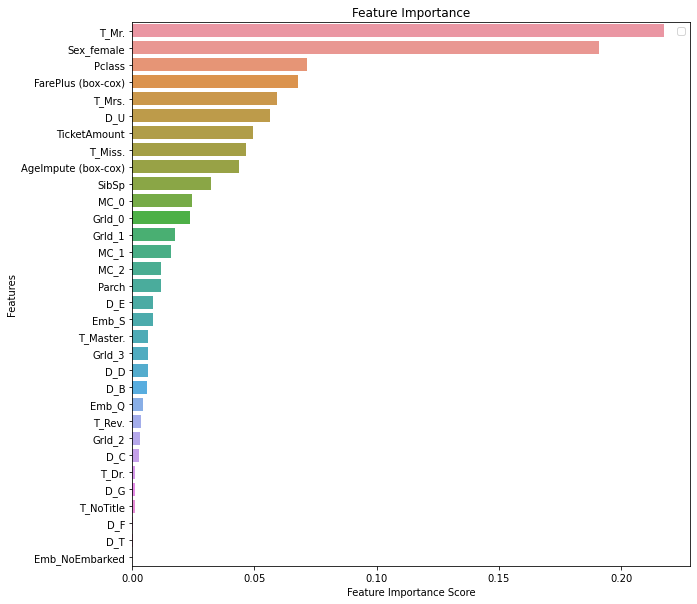

In [312]:
forest = RandomForestClassifier(n_estimators = 200, max_depth=5, random_state=4)
forest.fit(x1, y1)

print(forest.score(x1, y1))

feature_imp = pd.Series(forest.feature_importances_,index=names).sort_values(ascending=False)
print(feature_imp)

%matplotlib inline
# Creating a bar plot
plt.figure(figsize=(10,10))
plt.title("Feature importances")
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.legend()
plt.show()

In [313]:
RandomForestPrediction = forest.predict(data_toPredict5)
RandomForestPrediction = [int(x) for x in RandomForestPrediction]
print(RandomForestPrediction)
print(type(RandomForestPrediction[0]))

[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 

In [314]:
data_toPredict5['Survived'] = RandomForestPrediction

In [315]:
submission = data_toPredict5[['Survived']]

In [316]:
submission.to_csv("C:/Users/meykevandenbos/Documents/Meyke persoonlijk/Techionista/Titanic/prediction_submission29032121-3.csv")

In [317]:
data_train5B = data.loc[(data['Survived'].notna())]
data_toPredict5B = data.loc[(data['Survived'].isna())]

In [318]:
# Now without MC
data_train5B = data_train5B[['Survived',
 'Pclass',
 'SibSp',
 'Parch',
 'Sex_female',
 'Emb_NoEmbarked',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'T_NoTitle',
 'T_Rev.',
 'D_B',
 'D_C',
 'D_D',
 'D_E',
 'D_F',
 'D_G',
 'D_T',
 'D_U',
 'FarePlus (box-cox)',
 'AgeImpute (box-cox)',
 'dummySurvived',
 'TicketAmount',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']]

In [320]:
data_toPredict5B = data_toPredict5B[['Pclass',
 'SibSp',
 'Parch',
 'Sex_female',
 'Emb_NoEmbarked',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'T_NoTitle',
 'T_Rev.',
 'D_B',
 'D_C',
 'D_D',
 'D_E',
 'D_F',
 'D_G',
 'D_T',
 'D_U',
 'FarePlus (box-cox)',
 'AgeImpute (box-cox)',
 'dummySurvived',
 'TicketAmount',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']]

In [321]:
x1 = data_train5B.drop(columns=["Survived"]).values
y1 = data_train5B["Survived"].values

In [322]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, train_size=0.8, test_size=0.2, random_state=1)

In [326]:
random_state = 4
modelRF = RandomForestClassifier(random_state=4)
parameters = {"n_estimators": [500,750,1000],
             "max_depth": [4,6],
             "max_features": ["auto", "log2", None]}

kfold = KFold(n_splits=3, random_state=random_state, shuffle = True)
cv = GridSearchCV(modelRF, param_grid = parameters, cv=kfold, scoring = "accuracy")
cv.fit(x1_train, y1_train)

y1_predict = cv.predict(x1_test)
y1_pred_proba = cv.predict_proba(x1_test)[:,1]

print("Accuracy train: {}".format(cv.score(x1_train, y1_train)))
print("Accuracy test: {}".format(cv.score(x1_test, y1_test)))
print("AUC score: {}".format(roc_auc_score(y1_test, y1_pred_proba)))
print("Tuned Model Parameters: {}".format(cv.best_params_))
print(confusion_matrix(y1_test, y1_predict))
print(classification_report(y1_test, y1_predict))

Accuracy train: 0.851123595505618
Accuracy test: 0.8212290502793296
AUC score: 0.8621090721116568
Tuned Model Parameters: {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}
[[95 11]
 [21 52]]
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86       106
         1.0       0.83      0.71      0.76        73

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



In [327]:
names = data_toPredict5B.columns.tolist()

0.8462401795735129
Sex_female             0.207993
T_Mr.                  0.192257
dummySurvived          0.134149
Pclass                 0.062709
T_Miss.                0.062000
FarePlus (box-cox)     0.058218
T_Mrs.                 0.056406
D_U                    0.052700
TicketAmount           0.039792
AgeImpute (box-cox)    0.029104
SibSp                  0.021144
GrId_0                 0.017890
GrId_1                 0.010912
Parch                  0.009824
Emb_S                  0.006923
D_E                    0.006666
D_B                    0.005420
T_Master.              0.005249
GrId_3                 0.004696
D_D                    0.004648
Emb_Q                  0.003091
T_Rev.                 0.002100
GrId_2                 0.002000
D_C                    0.001989
T_NoTitle              0.000911
T_Dr.                  0.000598
D_F                    0.000331
D_G                    0.000227
D_T                    0.000031
Emb_NoEmbarked         0.000023
dtype: float64


No handles with labels found to put in legend.


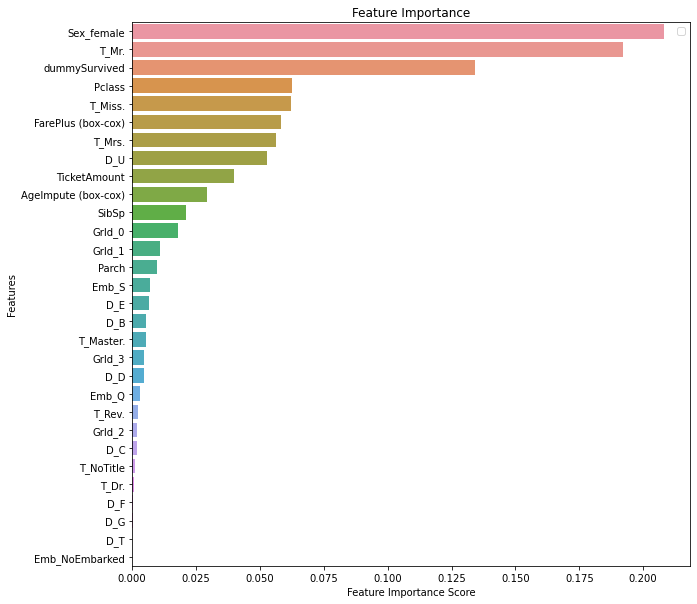

In [328]:
forest = RandomForestClassifier(n_estimators = 500, max_depth=4, random_state=4)
forest.fit(x1, y1)

print(forest.score(x1, y1))

feature_imp = pd.Series(forest.feature_importances_,index=names).sort_values(ascending=False)
print(feature_imp)

%matplotlib inline
# Creating a bar plot
plt.figure(figsize=(10,10))
plt.title("Feature importances")
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.legend()
plt.show()

In [329]:
RandomForestPrediction = forest.predict(data_toPredict5B)
RandomForestPrediction = [int(x) for x in RandomForestPrediction]
print(RandomForestPrediction)
print(type(RandomForestPrediction[0]))

[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 

In [330]:
data_toPredict5B['Survived'] = RandomForestPrediction

In [331]:
submission = data_toPredict5B[['Survived']]

In [332]:
submission.to_csv("C:/Users/meykevandenbos/Documents/Meyke persoonlijk/Techionista/Titanic/prediction_submission29032121-4.csv")

##### RandomForest 4 - with grouping for the continuous variables

In [335]:
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute,Age (box-cox),AgeImpute (box-cox),FamilyCount,dummySurvived,MC_0,MC_1,MC_2,TicketAmount,CabinAmount,GrId_0,GrId_1,GrId_2,GrId_3
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,22.0,1,0,7.2500,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.399674,22.0,13.219923,13.803786,2,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
2,1.0,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,6.539036,38.0,21.015717,22.155164,2,0,0.0,0.0,0.0,2,2,3.0,-1.0,0.0,0.0
3,1.0,3,26.0,0,0,7.9250,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2.529854,26.0,15.257660,15.977543,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0
4,1.0,1,35.0,1,0,53.1000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,5.900956,35.0,19.617894,20.651225,2,0,0.0,0.0,0.0,2,2,2.0,-4.0,0.0,0.0
5,0.0,3,35.0,0,0,8.0500,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.552966,35.0,19.617894,20.651225,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0


Overall, there are two continuous variables: fare and age. I created a few more but I will focus on the two original variables to create groups. 

First for Age, after for Fare.

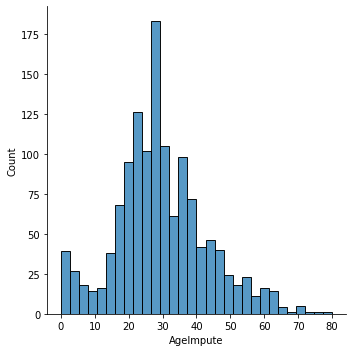

In [341]:
sns.displot(data, x='AgeImpute')

In [344]:
data['AgeGroups'] = data.apply(lambda row: 1 if row.AgeImpute < 11 else
                              (2 if row.AgeImpute < 31 else
                              (3 if row.AgeImpute < 51 else 4)), axis = 1)

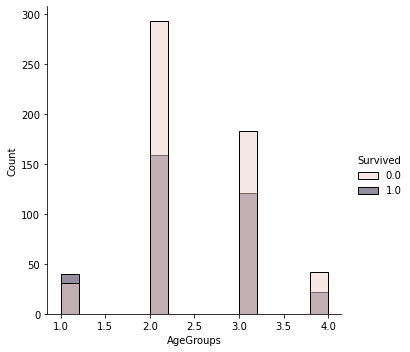

In [346]:
sns.displot(data, x='AgeGroups', hue='Survived')

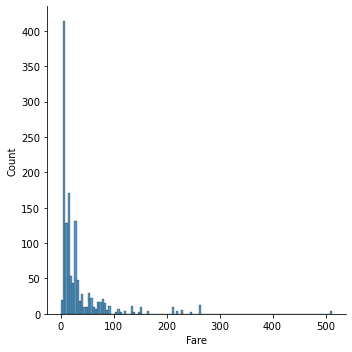

In [352]:
sns.displot(data, x='Fare')

In [353]:
data['FareGroups'] = data.apply(lambda row: 1 if row.Fare < 20 else
                               (2 if row.Fare < 40 else
                               (3 if row.Fare < 80 else
                               (4 if row.Fare < 100 else
                               (5 if row.Fare < 200 else 6)))), axis=1)

In [356]:
data['FareGroups2'] = data.apply(lambda row: 1 if row.Fare < 10 else
                               (2 if row.Fare < 20 else
                               (3 if row.Fare < 40 else
                               (4 if row.Fare < 80 else
                               (5 if row.Fare < 100 else 6)))), axis=1)

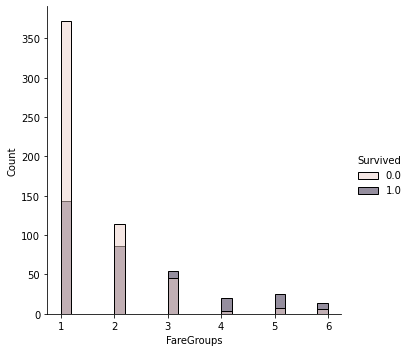

In [355]:
sns.displot(data, x='FareGroups', hue='Survived')

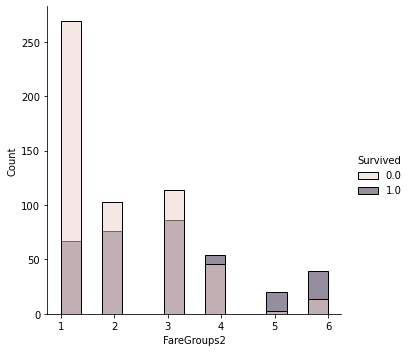

In [357]:
sns.displot(data, x='FareGroups2', hue='Survived')

In [359]:
data_train6 = data.loc[(data['Survived'].notna())]
data_toPredict6 = data.loc[(data['Survived'].isna())]

In [360]:
data_train6.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Emb_C,Emb_NoEmbarked,Emb_Q,Emb_S,T_Dr.,T_Master.,T_Miss.,T_Mr.,T_Mrs.,T_NoTitle,T_Rev.,D_A,D_B,D_C,D_D,D_E,D_F,D_G,D_T,D_U,FarePlus (box-cox),AgeImpute,Age (box-cox),AgeImpute (box-cox),FamilyCount,dummySurvived,MC_0,MC_1,MC_2,TicketAmount,CabinAmount,GrId_0,GrId_1,GrId_2,GrId_3,AgeGroups,FareGroups,FareGroups2
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,22.0,1,0,7.2500,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.399674,22.0,13.219923,13.803786,2,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,2,1,1
2,1.0,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,6.539036,38.0,21.015717,22.155164,2,0,0.0,0.0,0.0,2,2,3.0,-1.0,0.0,0.0,3,3,4
3,1.0,3,26.0,0,0,7.9250,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2.529854,26.0,15.257660,15.977543,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,2,1,1
4,1.0,1,35.0,1,0,53.1000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,5.900956,35.0,19.617894,20.651225,2,0,0.0,0.0,0.0,2,2,2.0,-4.0,0.0,0.0,3,3,4
5,0.0,3,35.0,0,0,8.0500,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.552966,35.0,19.617894,20.651225,1,0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,3,1,1


In [362]:
data_train6 = data_train6[['Survived',
 'Pclass',
 'SibSp',
 'Parch',
 'Sex_female',
 'Emb_NoEmbarked',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'T_NoTitle',
 'T_Rev.',
 'D_B',
 'D_C',
 'D_D',
 'D_E',
 'D_F',
 'D_G',
 'D_T',
 'D_U',
 'FareGroups2',
 'AgeGroups',
 'dummySurvived',
 'TicketAmount',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']]

In [363]:
data_toPredict6 = data_toPredict6[['Pclass',
 'SibSp',
 'Parch',
 'Sex_female',
 'Emb_NoEmbarked',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'T_NoTitle',
 'T_Rev.',
 'D_B',
 'D_C',
 'D_D',
 'D_E',
 'D_F',
 'D_G',
 'D_T',
 'D_U',
 'FareGroups2',
 'AgeGroups',
 'dummySurvived',
 'TicketAmount',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']]

In [364]:
x1 = data_train6.drop(columns=["Survived"]).values
y1 = data_train6["Survived"].values

In [365]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, train_size=0.8, test_size=0.2, random_state=1)

In [369]:
random_state = 4
modelRF = RandomForestClassifier(random_state=4)
parameters = {"n_estimators": [600,750,800],
             "max_depth": [4,5,6],
             "max_features": ["auto", "log2", None]}

kfold = KFold(n_splits=3, random_state=random_state, shuffle = True)
cv = GridSearchCV(modelRF, param_grid = parameters, cv=kfold, scoring = "accuracy")
cv.fit(x1_train, y1_train)

y1_predict = cv.predict(x1_test)
y1_pred_proba = cv.predict_proba(x1_test)[:,1]

print("Accuracy train: {}".format(cv.score(x1_train, y1_train)))
print("Accuracy test: {}".format(cv.score(x1_test, y1_test)))
print("AUC score: {}".format(roc_auc_score(y1_test, y1_pred_proba)))
print("Tuned Model Parameters: {}".format(cv.best_params_))
print(confusion_matrix(y1_test, y1_predict))
print(classification_report(y1_test, y1_predict))

Accuracy train: 0.8651685393258427
Accuracy test: 0.8268156424581006
AUC score: 0.8606228999741534
Tuned Model Parameters: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 750}
[[96 10]
 [21 52]]
              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86       106
         1.0       0.84      0.71      0.77        73

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179



In [370]:
names = data_toPredict6.columns.tolist()

No handles with labels found to put in legend.


0.856341189674523
T_Mr.             0.193471
Sex_female        0.183653
dummySurvived     0.142486
Pclass            0.069740
T_Miss.           0.063168
T_Mrs.            0.053967
D_U               0.053752
TicketAmount      0.045306
FareGroups2       0.039906
SibSp             0.024755
GrId_0            0.020479
GrId_1            0.017191
Parch             0.015990
AgeGroups         0.015640
Emb_S             0.009978
D_E               0.008177
T_Master.         0.007695
GrId_3            0.006404
D_B               0.005382
D_D               0.005219
Emb_Q             0.004425
GrId_2            0.003465
D_C               0.003156
T_Rev.            0.002875
T_NoTitle         0.001168
T_Dr.             0.001114
D_F               0.000767
D_G               0.000634
Emb_NoEmbarked    0.000020
D_T               0.000017
dtype: float64


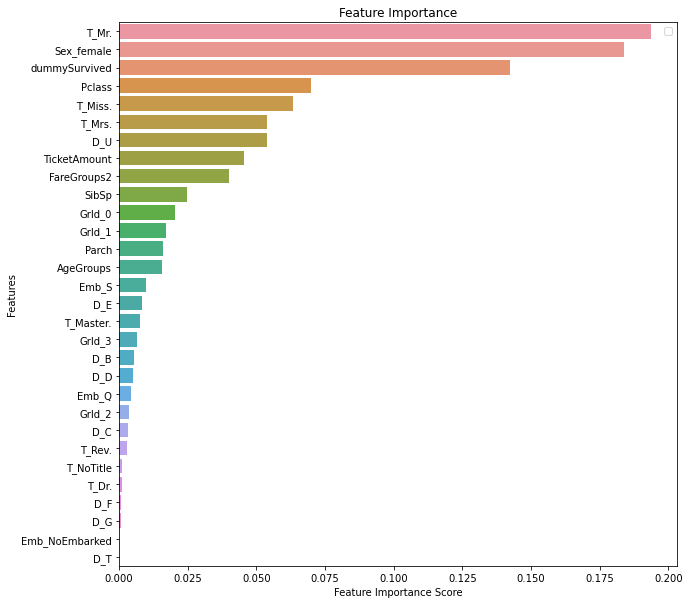

In [371]:
forest = RandomForestClassifier(n_estimators = 750, max_depth=5, random_state=4, max_features="auto")
forest.fit(x1, y1)

print(forest.score(x1, y1))

feature_imp = pd.Series(forest.feature_importances_,index=names).sort_values(ascending=False)
print(feature_imp)

%matplotlib inline
# Creating a bar plot
plt.figure(figsize=(10,10))
plt.title("Feature importances")
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.legend()
plt.show()

In [372]:
RandomForestPrediction = forest.predict(data_toPredict6)
RandomForestPrediction = [int(x) for x in RandomForestPrediction]
print(RandomForestPrediction)
print(type(RandomForestPrediction[0]))

[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 

In [373]:
data_toPredict6['Survived'] = RandomForestPrediction

In [374]:
submission = data_toPredict6[['Survived']]

In [375]:
submission.to_csv("C:/Users/meykevandenbos/Documents/Meyke persoonlijk/Techionista/Titanic/prediction_submission30032121-1.csv")

##### RandomForest 5 - less features

In [392]:
data_train7 = data.loc[(data['Survived'].notna())]
data_toPredict7 = data.loc[(data['Survived'].isna())]

In [393]:
data_train7 = data_train7[['Survived',
 'Pclass',
 'SibSp',
 'Parch',
 'Sex_female',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'D_B',
 'D_D',
 'D_E',
 'D_U',
 'FareGroups2',
 'AgeGroups',
 'dummySurvived',
 'TicketAmount',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']]

In [394]:
data_toPredict7 = data_toPredict7[['Pclass',
 'SibSp',
 'Parch',
 'Sex_female',
 'Emb_Q',
 'Emb_S',
 'T_Dr.',
 'T_Master.',
 'T_Miss.',
 'T_Mr.',
 'T_Mrs.',
 'D_B',
 'D_D',
 'D_E',
 'D_U',
 'FareGroups2',
 'AgeGroups',
 'dummySurvived',
 'TicketAmount',
 'GrId_0',
 'GrId_1',
 'GrId_2',
 'GrId_3']]

In [395]:
x1 = data_train7.drop(columns=["Survived"]).values
y1 = data_train7["Survived"].values

In [396]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, train_size=0.8, test_size=0.2, random_state=1)

In [389]:
random_state = 4
modelRF = RandomForestClassifier(random_state=4)
parameters = {"n_estimators": [500,750,1000],
             "max_depth": [4,6,8],
             "max_features": ["auto", "log2", None]}

kfold = KFold(n_splits=3, random_state=random_state, shuffle = True)
cv = GridSearchCV(modelRF, param_grid = parameters, cv=kfold, scoring = "accuracy")
cv.fit(x1_train, y1_train)

y1_predict = cv.predict(x1_test)
y1_pred_proba = cv.predict_proba(x1_test)[:,1]

print("Accuracy train: {}".format(cv.score(x1_train, y1_train)))
print("Accuracy test: {}".format(cv.score(x1_test, y1_test)))
print("AUC score: {}".format(roc_auc_score(y1_test, y1_pred_proba)))
print("Tuned Model Parameters: {}".format(cv.best_params_))
print(confusion_matrix(y1_test, y1_predict))
print(classification_report(y1_test, y1_predict))

Accuracy train: 0.8876404494382022
Accuracy test: 0.8100558659217877
AUC score: 0.8741922977513571
Tuned Model Parameters: {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 1000}
[[97  9]
 [25 48]]
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.85       106
         1.0       0.84      0.66      0.74        73

    accuracy                           0.81       179
   macro avg       0.82      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [390]:
random_state = 4
modelRF = RandomForestClassifier(random_state=4)
parameters = {"n_estimators": [750,1000,1250],
             "max_depth": [5,6,7],
             "max_features": ["auto", "log2", None]}

kfold = KFold(n_splits=3, random_state=random_state, shuffle = True)
cv = GridSearchCV(modelRF, param_grid = parameters, cv=kfold, scoring = "accuracy")
cv.fit(x1_train, y1_train)

y1_predict = cv.predict(x1_test)
y1_pred_proba = cv.predict_proba(x1_test)[:,1]

print("Accuracy train: {}".format(cv.score(x1_train, y1_train)))
print("Accuracy test: {}".format(cv.score(x1_test, y1_test)))
print("AUC score: {}".format(roc_auc_score(y1_test, y1_pred_proba)))
print("Tuned Model Parameters: {}".format(cv.best_params_))
print(confusion_matrix(y1_test, y1_predict))
print(classification_report(y1_test, y1_predict))

Accuracy train: 0.8637640449438202
Accuracy test: 0.8324022346368715
AUC score: 0.8679891444817782
Tuned Model Parameters: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 750}
[[97  9]
 [21 52]]
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87       106
         1.0       0.85      0.71      0.78        73

    accuracy                           0.83       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



In [398]:
names = data_toPredict7.columns.tolist()

No handles with labels found to put in legend.


0.8540965207631874
T_Mr.            0.203983
Sex_female       0.188787
dummySurvived    0.150737
Pclass           0.073641
T_Miss.          0.055853
D_U              0.054611
T_Mrs.           0.045789
FareGroups2      0.043488
TicketAmount     0.043186
SibSp            0.022462
GrId_0           0.020654
AgeGroups        0.015846
GrId_1           0.015774
Parch            0.015149
Emb_S            0.009692
D_E              0.007783
GrId_3           0.007451
T_Master.        0.005974
D_D              0.005084
D_B              0.004824
Emb_Q            0.004460
GrId_2           0.003574
T_Dr.            0.001196
dtype: float64


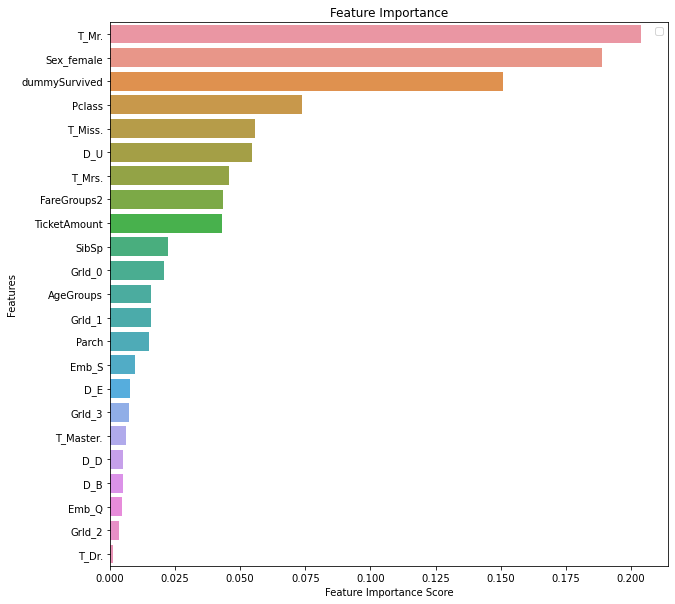

In [399]:
forest = RandomForestClassifier(n_estimators = 750, max_depth=5, random_state=4, max_features="auto")
forest.fit(x1, y1)

print(forest.score(x1, y1))

feature_imp = pd.Series(forest.feature_importances_,index=names).sort_values(ascending=False)
print(feature_imp)

%matplotlib inline
# Creating a bar plot
plt.figure(figsize=(10,10))
plt.title("Feature importances")
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.legend()
plt.show()

In [400]:
RandomForestPrediction = forest.predict(data_toPredict7)
RandomForestPrediction = [int(x) for x in RandomForestPrediction]
print(RandomForestPrediction)
print(type(RandomForestPrediction[0]))

[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 

In [401]:
data_toPredict6['Survived'] = RandomForestPrediction

In [402]:
submission = data_toPredict6[['Survived']]

In [403]:
submission.to_csv("C:/Users/meykevandenbos/Documents/Meyke persoonlijk/Techionista/Titanic/prediction_submission30032121-2.csv")